### 加載資料

In [570]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from collections import defaultdict
import math
from arch.unitroot import KPSS
from hurst import compute_Hc

def prepare_data(type_of_data, data_name):
    result = type_of_data.split('/')[0]
    tmp = pd.read_csv(f'./index_data/{type_of_data}/{data_name}.csv')
    if result == 'shioaji':
        tmp['ts'] = pd.to_datetime(tmp['ts'])
        tmp = tmp.rename(columns=lambda x: x.lower())
    else:
        tmp['ts'] = pd.to_datetime(tmp['datetime'])
        tmp = tmp.rename(columns=lambda x: x.lower())
    
    return tmp

# A (價格較貴的或期貨)
df1 = prepare_data('shioaji/2025_0406', 'QXFR1')
df3 = prepare_data('shioaji/2025_0406', 'QXFR1k')
df3.set_index("ts", inplace=True)

# B (價格較便宜的或股票)
df2 = prepare_data('shioaji/2025_0406', 'DAFR1')
df4 = prepare_data('shioaji/2025_0406', 'DAFR1k')
df4.set_index("ts", inplace=True)

# 自定義函數處理 tick_type 分析
def analyze_tick_types(tick_types):
    """
    分析該秒內的成交類型分布
    :param tick_types: Series, 該秒內的 tick_type 列表
    :return: dict, 包括內盤、外盤成交數量及主要成交方向
    """
    tick_types = tick_types.tolist()  # 轉換為列表
    outer_trades = tick_types.count(1)  # 外盤成交數量
    inner_trades = tick_types.count(-1)  # 內盤成交數量
    net_trades = outer_trades - inner_trades  # 淨成交量
    dominant = "外盤" if net_trades > 0 else "內盤" if net_trades < 0 else "均衡"
    return {
        "outer_trades": outer_trades,
        "inner_trades": inner_trades,
        "dominant": dominant
    }

# 資料時間調整 # day日盤, night夜盤
def pre_process(df1, data_type, date_start, date_end):
    # 假设你的df已经加载到dataframe
    df1['ts'] = pd.to_datetime(df1['ts'])  # 将ts列转换为datetime类型

    # 按秒分组
    df1 = df1.groupby(df1['ts'].dt.floor('s')).agg({
        'close': 'last', 
        'volume': 'sum', 
        'bid_price': lambda x: tuple(sorted(filter(lambda price: price != 0, x))), 
        'bid_volume': 'sum', 
        'ask_price': lambda x: tuple(sorted(filter(lambda price: price != 0, x))), 
        'ask_volume': 'sum', 
        'tick_type': lambda x: analyze_tick_types(x)
    }).reset_index()
    
    # 過濾掉 bid_price 或 ask_price 為空 tuple 的行 (漲停或跌停)
    df1 = df1[(df1['bid_price'].map(len) > 0) & (df1['ask_price'].map(len) > 0)]
    
    # 展開內盤、外盤和主要成交方向
    df1['outer_trades'] = df1['tick_type'].apply(lambda x: x['outer_trades'])
    df1['inner_trades'] = df1['tick_type'].apply(lambda x: x['inner_trades'])
    df1['dominant'] = df1['tick_type'].apply(lambda x: x['dominant'])
    
    # 刪除原始的 tick_type 列
    df1.drop(columns=['tick_type'], inplace=True)

    # 创建时间范围从開始到結束天數（或多个天数），每天包含9:00:00到13:30:00之间的每一秒
    time_range = pd.date_range(date_start, date_end, freq='s')

    # 将时间范围转换为DataFrame
    full_time_df = pd.DataFrame(time_range, columns=['ts'])
    
    if data_type == 's_day':
        # 通过检查时间是否在9:00:00到13:30:00之间来剔除跨天的数据
        valid_time_range = full_time_df['ts'].dt.time.between(pd.to_datetime('09:00:00').time(), pd.to_datetime('13:30:00').time())
        valid_time = full_time_df[valid_time_range]
        
    elif data_type == 'f_day':
        # 通过检查时间是否在9:00:00到13:30:00之间来剔除跨天的数据
        valid_time_range = full_time_df['ts'].dt.time.between(pd.to_datetime('08:45:00').time(), pd.to_datetime('13:45:00').time())
        valid_time = full_time_df[valid_time_range]
        
    elif data_type == 'f_night':
        # 定义有效时间范围
        def is_valid_time(time):
            # 日盘时间：09:00:00 到 13:30:00
            if time.time() >= pd.to_datetime('08:45:00').time() and time.time() <= pd.to_datetime('13:45:00').time():
                return True
            # 夜盘时间：15:00:00 到 隔天 04:00:00
            elif time.time() >= pd.to_datetime('15:00:00').time() or time.time() <= pd.to_datetime('05:00:00').time():
                return True
            else:
                return False

        # 筛选出有效时间
        valid_time = full_time_df[full_time_df['ts'].apply(is_valid_time)]

    # 合并df1和df2的结果，确保它们与mer_ori_data按秒对齐, 首先将df1和df2与mer_ori_data合并，使用'left'连接方式，以保留所有有效时间
    mer_ori_data = pd.merge(valid_time, df1, on='ts', how='left')

    # 设置'ts'为index
    mer_ori_data.set_index('ts', inplace=True)

    # 删除含有NaN的行
    mer_ori_data = mer_ori_data.dropna()
    
    return mer_ori_data

df1 = pre_process(df1, 'f_day', '2025-04-01 08:45:00', '2025-06-05 13:45:00')
df2 = pre_process(df2, 'f_day', '2025-04-01 08:45:00', '2025-06-05 13:45:00')

df = pd.merge(
    df1, 
    df2, 
    left_index=True, 
    right_index=True, 
    how='outer', 
    suffixes=('_df1', '_df2')
)

# 按时间索引排序确保前向填充正确进行 
df = df.sort_index().dropna()

def analyze_relationship(series1, series2, significance_level=0.05):
    # 計算相關係數
    correlation = np.corrcoef(series1, series2)[0, 1]
    abs_corr = abs(correlation)
    
    # 判斷相關性強度
    if abs_corr > 0.8:
        correlation_strength = "高度相關"
    elif abs_corr > 0.5:
        correlation_strength = "中度相關"
    elif abs_corr > 0.3:
        correlation_strength = "低度相關"
    else:
        correlation_strength = "幾乎無相關"
    
    # 執行共整合檢定
    coint_t, p_value, _ = coint(series1, series2)
    
    # 判斷是否存在共整合關係
    if p_value <= significance_level:
        cointegration_status = "存在共整合關係"
    else:
        cointegration_status = "不存在共整合關係"
        
    print(f"相關係數: {correlation:.4f}，{correlation_strength}")
    print(f"共整合檢定的 p 值: {p_value:.4f}，{cointegration_status}")
    
    return correlation, correlation_strength, p_value, cointegration_status

def analyze(trade_result, is_plot=False):
    """
    分析交易結果，計算各項績效指標，基於收益率而非金額。
    
    參數:
    - trade_result: 交易記錄列表，每筆交易包含 'net_profit_loss', 'capital', 'timestamp', 'type'
    - is_plot: 是否繪製圖表
    
    返回:
    - 字典，包含績效指標
    """
    if not trade_result:
        return {
            'net_profit_loss': 0,
            'capital': 0,
            'win_count': 0,
            'loss_count': 0,
            'win_rate': 0,
            'max_drawdown': 0,
            'annualized_return': 0,
            'sharpe_ratio': 0,
            'sterling_ratio': 0,
            'omega_ratio': 0,
            'sortino_ratio': 0,
            'skewness': 0,
            'kurtosis': 0,
            'overall_conclusion': 'No trades to analyze.',
            'total_trades': 0,
            'type_performance': {}
        }

    # 計算總盈虧（金額）和勝負次數
    total_profit_loss = sum(trade['net_profit_loss'] for trade in trade_result)
    win_count = sum(1 for trade in trade_result if trade['net_profit_loss'] > 0)
    loss_count = sum(1 for trade in trade_result if trade['net_profit_loss'] < 0)
    win_rate = win_count / len(trade_result) if trade_result else 0
    total_trades = len(trade_result)
    capital = trade_result[-1]['capital']

    # 計算資本曲線與最大回撤（金額）
    equity_curve = [trade['capital'] for trade in trade_result]
    peak = equity_curve[0]
    max_drawdown = 0
    drawdown_curve = []
    for value in equity_curve:
        peak = max(peak, value)
        drawdown = peak - value
        drawdown_curve.append(drawdown)
        max_drawdown = max(max_drawdown, drawdown)

    # 計算收益率
    returns = [trade['net_profit_loss'] / trade['capital'] for trade in trade_result]
    n = len(returns)

    # 年化回報（基於收益率）
    total_return = sum(returns)
    annualized_return = (total_return / n * 252) if n > 0 else 0

    # 夏普比率
    avg_return = total_return / n if n > 0 else 0
    return_std = (sum((x - avg_return) ** 2 for x in returns) / n) ** 0.5 if n > 0 else 0
    annualized_std = return_std * math.sqrt(252)
    risk_free_rate = 0
    sharpe_ratio = ((annualized_return - risk_free_rate) / (annualized_std + 1e-9)) if annualized_std > 0 else 0

    # Sortino Ratio
    downside_returns = [min(0, x - risk_free_rate) for x in returns]
    downside_std = (sum(d**2 for d in downside_returns) / n) ** 0.5 if n > 0 else 0
    annualized_downside_std = downside_std * math.sqrt(252)
    sortino_ratio = ((annualized_return - risk_free_rate) / (annualized_downside_std + 1e-9)) if annualized_downside_std > 0 else 0

    # Sterling Ratio（使用相對回撤）
    relative_drawdown = max_drawdown / peak if peak > 0 else 0
    sterling_ratio = (annualized_return / (relative_drawdown + 1e-9)) if relative_drawdown > 0 else 0

    # Omega Ratio
    tau = 0
    excess_gains = [max(x - tau, 0) for x in returns]
    excess_losses = [max(tau - x, 0) for x in returns]
    omega_ratio = (sum(excess_gains) / (sum(excess_losses) + 1e-9)) if n > 0 else 0

    # 偏態與峭度
    if n > 0 and return_std > 0:
        skewness = sum((x - avg_return)**3 for x in returns) / (n * (return_std**3))
        kurtosis = sum((x - avg_return)**4 for x in returns) / (n * (return_std**4)) - 3
    else:
        skewness = 0
        kurtosis = 0

    # 肥尾與偏態結論
    fat_tail_conclusion = "收益分布具有肥尾特徵，極端值較常見。" if kurtosis > 0 else "收益分布尾部較薄，極端值較少。"
    skewness_conclusion = (
        "收益分布呈正偏態，偶有較大正收益。" if skewness > 0 else
        "收益分布呈負偏態，偶有較大負收益。" if skewness < 0 else
        "收益分布基本對稱。"
    )
    overall_conclusion = f"{fat_tail_conclusion} {skewness_conclusion}"

    # 按 type 計算績效（保留金額形式）
    type_performance = defaultdict(lambda: {
        'total_trades': 0,
        'win_count': 0,
        'loss_count': 0,
        'win_rate': 0,
        'total_profit_loss': 0,
        'profit_timestamps': [],
        'loss_timestamps': []
    })
    
    for trade in trade_result:
        trade_type = trade['type']
        timestamp = trade['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
        
        type_performance[trade_type]['total_trades'] += 1
        type_performance[trade_type]['total_profit_loss'] += trade['net_profit_loss']
        
        if trade['net_profit_loss'] > 0:
            type_performance[trade_type]['win_count'] += 1
            type_performance[trade_type]['profit_timestamps'].append(timestamp)
        elif trade['net_profit_loss'] < 0:
            type_performance[trade_type]['loss_count'] += 1
            type_performance[trade_type]['loss_timestamps'].append(timestamp)

    for trade_type, performance in type_performance.items():
        performance['win_rate'] = (
            performance['win_count'] / performance['total_trades']
            if performance['total_trades'] > 0 else 0
        )

    # 繪圖
    if is_plot:
        fig, axs = plt.subplots(3, 1, figsize=(12, 6))
        axs[0].plot(equity_curve, label="Equity (Capital) Curve", color="green")
        axs[0].set_title("Equity Curve")
        axs[0].set_ylabel("Capital")
        axs[0].legend()

        axs[1].plot(drawdown_curve, label="Max Drawdown", color="red")
        axs[1].set_title("Max Drawdown")
        axs[1].set_ylabel("Drawdown")
        axs[1].legend()

        cumulative_returns = [sum(returns[:i+1]) for i in range(len(returns))]
        axs[2].plot(cumulative_returns, label="Cumulative Return", color="blue")
        axs[2].set_title("Cumulative Return")
        axs[2].set_ylabel("Cumulative Return")
        axs[2].legend()

        plt.tight_layout()
        plt.show()

    return {
        'net_profit_loss': total_profit_loss,
        'capital': capital,
        'win_count': win_count,
        'loss_count': loss_count,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'annualized_return': annualized_return,
        'sharpe_ratio': sharpe_ratio,
        'sterling_ratio': sterling_ratio,
        'omega_ratio': omega_ratio,
        'sortino_ratio': sortino_ratio,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'overall_conclusion': overall_conclusion,
        'total_trades': total_trades,
        'type_performance': dict(type_performance)
    }
    
def convert_ohlcv(df, freq=60):
    # 建立 session_type 與 session_start
    def classify_session(ts):
        time = ts.time()
        if datetime.strptime("08:45", "%H:%M").time() <= time <= datetime.strptime("13:45", "%H:%M").time():
            session_type = "day"
            session_date = ts.date()
            session_start = datetime.combine(session_date, datetime.strptime("08:45", "%H:%M").time())
        elif time >= datetime.strptime("15:00", "%H:%M").time():
            session_type = "night"
            session_date = ts.date()
            session_start = datetime.combine(session_date, datetime.strptime("15:00", "%H:%M").time())
        elif time <= datetime.strptime("05:00", "%H:%M").time():
            session_type = "night"
            session_date = (ts - timedelta(days=1)).date()
            session_start = datetime.combine(session_date, datetime.strptime("15:00", "%H:%M").time())
        else:
            return pd.Series(["other", pd.NaT])
        return pd.Series([session_type, session_start])

    df[["session_type", "session_start"]] = df.index.to_series().apply(classify_session)
    df = df[df["session_type"].isin(["day", "night"])]

    # ✅ 將 index 向前推 1 分鐘
    df.index = df.index - pd.Timedelta(minutes=1)

    # 設定 K 棒時間長度
    window = timedelta(minutes=freq)

    # 分段處理每個 session 的資料
    result = []

    for session_start, session_data in df.groupby("session_start"):
        current_time = session_start
        max_time = session_data.index.max()

        while current_time < max_time:
            next_time = current_time + window
            window_data = session_data[(session_data.index >= current_time) & (session_data.index < next_time)]

            if not window_data.empty:
                o = window_data["open"].iloc[0]
                h = window_data["high"].max()
                l = window_data["low"].min()
                c = window_data["close"].iloc[-1]
                v = window_data["volume"].sum()
                complete = window_data.index[-1] >= next_time - timedelta(minutes=1)

                result.append({
                    "ts": current_time,
                    "open": o,
                    "high": h,
                    "low": l,
                    "close": c,
                    "volume": v,
                    "complete": complete
                })

            current_time = next_time

    # 建立新的 DataFrame
    agg_df = pd.DataFrame(result)
    agg_df.set_index("ts", inplace=True, drop=False)

    return agg_df

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(series, window=20, num_std=2):
    """
    計算布林通道
    """
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    return {
        'mean': rolling_mean,
        'upper': upper_band,
        'lower': lower_band,
        'std': rolling_std
    }
    
def calculate_vwap(df, window, include_std_bands=False):
    """
    計算滾動窗口的 VWAP，並可選擇為 5 分鐘 K 線計算標準差帶。
    
    參數:
    - df: Pandas DataFrame，包含 'open', 'high', 'low', 'close', 'volume' 列
    - window: 滾動窗口大小（K 線數量）
    - include_std_bands: 是否計算標準差帶（僅用於 5 分鐘 K 線）
    
    返回:
    - DataFrame，包含原始數據和新計算的列：
      - 'vwap': 滾動 VWAP 值
      - 若 include_std_bands=True，額外包含：
        - 'vwap_upper_1std', 'vwap_lower_1std': ±1 標準差帶
        - 'vwap_upper_2std', 'vwap_lower_2std': ±2 標準差帶
    """
    # 複製輸入 DataFrame，避免修改原始數據
    df = df.copy()
    
    # 計算典型價格 (High + Low + Close) / 3
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
    
    # 計算價格 × 成交量
    df['price_volume'] = df['typical_price'] * df['volume']
    
    # 計算滾動窗口的 VWAP
    df['cum_price_volume'] = df['price_volume'].rolling(window=window, min_periods=1).sum()
    df['cum_volume'] = df['volume'].rolling(window=window, min_periods=1).sum()
    df['vwap'] = df['cum_price_volume'] / df['cum_volume']
    
    # 如果需要計算標準差帶（僅 5 分鐘 K 線）
    if include_std_bands:
        # 計算典型價格相對於 VWAP 的平方差
        df['price_diff_squared'] = (df['typical_price'] - df['vwap']) ** 2
        # 計算滾動標準差
        df['std'] = np.sqrt(df['price_diff_squared'].rolling(window=window, min_periods=1).mean())
        # 計算 ±1 和 ±2 標準差帶
        df['vwap_upper_2std'] = df['vwap'] + 2 * df['std']
        df['vwap_lower_2std'] = df['vwap'] - 2 * df['std']
        
        # 刪除中間計算列
        df = df.drop(columns=['price_diff_squared', 'std'])
    
    # 刪除中間計算列
    df = df.drop(columns=['typical_price', 'price_volume', 'cum_price_volume', 'cum_volume'])
    
    return df

def calculate_atr(df, window=14):
    """
    計算 ATR (Average True Range)
    
    參數:
    df (pd.DataFrame): 包含 'high', 'low', 'close' 欄位的 OHLCV 數據框
    window (int): 滾動窗口大小，預設為 14
    
    返回:
    pd.Series: 包含 ATR 值的序列，與輸入數據框的索引對齊
    """
    # 確保數據框包含必要的欄位
    if not all(col in df.columns for col in ['high', 'low', 'close']):
        raise ValueError("DataFrame must contain 'high', 'low', and 'close' columns")
    
    # 計算真實波幅 (True Range)
    # 1. high - low
    # 2. |high - prev_close|
    # 3. |low - prev_close|
    df['prev_close'] = df['close'].shift(1)  # 前一收盤價
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = abs(df['high'] - df['prev_close'])
    df['tr3'] = abs(df['low'] - df['prev_close'])
    
    # 真實波幅是三者的最大值
    df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
    
    # 使用滾動窗口計算 ATR（簡單移動平均）
    atr = df['tr'].rolling(window=window, min_periods=1).mean()
    
    # 清理臨時欄位
    df.drop(['prev_close', 'tr1', 'tr2', 'tr3', 'tr'], axis=1, inplace=True)
    
    return atr

def calculate_ema(df, span=5):
    return df.ewm(span=span, adjust=False).mean()

print(df.head(3))

                     close_df1  volume_df1 bid_price_df1  bid_volume_df1  \
ts                                                                         
2025-04-01 08:59:59       78.8         1.0       (78.8,)             1.0   
2025-04-01 09:00:02       78.6         1.0       (78.3,)             4.0   
2025-04-01 09:00:06       78.4         1.0       (78.3,)             4.0   

                    ask_price_df1  ask_volume_df1  outer_trades_df1  \
ts                                                                    
2025-04-01 08:59:59       (79.0,)             1.0               0.0   
2025-04-01 09:00:02       (79.0,)             1.0               0.0   
2025-04-01 09:00:06       (78.9,)             1.0               0.0   

                     inner_trades_df1 dominant_df1  close_df2  volume_df2  \
ts                                                                          
2025-04-01 08:59:59               0.0           均衡       75.3         1.0   
2025-04-01 09:00:02             

### 資料整理與轉換

In [571]:
# MXFR vs TMFR
# K_time = 45
# df_min_close_df1 = convert_ohlcv(df3, K_time)['close']
# df_min_close_df2 = convert_ohlcv(df4, K_time)['close']

# FXFR1 vs ZFFR1
# K_time = 5
# df_min_close_df1 = convert_ohlcv(df3, K_time)["close"]
# df_min_close_df2 = convert_ohlcv(df4, K_time)["close"]
# df_min_close_df1 = calculate_rsi(df_min_close_df1, 7)
# df_min_close_df2 = calculate_rsi(df_min_close_df2, 7)

# CKFR vs DDFR
# K_time = 5
# df_min_close_df1 = convert_ohlcv(df3, K_time)['close']
# df_min_close_df2 = convert_ohlcv(df4, K_time)['close']
# df_min_close_df1 = calculate_rsi(df_min_close_df1, 6)
# df_min_close_df2 = calculate_rsi(df_min_close_df2, 6)

# CKFR vs CEFR
# K_time = 5
# df_min_close_df1 = convert_ohlcv(df3, K_time)['close']
# df_min_close_df2 = convert_ohlcv(df4, K_time)['close']
# df_min_close_df1 = calculate_ema(df_min_close_df1, 5)
# df_min_close_df2 = calculate_ema(df_min_close_df2, 5)

# DAFR1 vs QXFR1
K_time = 5
df_min_close_df1 = convert_ohlcv(df3, K_time)['close']
df_min_close_df2 = convert_ohlcv(df4, K_time)['close']

### 時間序列整合(可選)

##### Bias乖離率

In [ ]:
def calculate_bias_ratio(df_close1, df_close2, ma_period, use_ratio=False):
    """
    計算K棒的乖離率 (Bias Ratio)
    
    參數:
        df_close1 (pd.Series): 第一資產的K棒收盤價
        df_close2 (pd.Series): 第二資產的K棒收盤價
        ma_period (int): 移動平均的週期 (K棒數)
        use_ratio (bool): 若為True，使用價格比率 (df_close1 / df_close2)；若為False，使用價格差異 (df_close1 - df_close2)
    
    返回:
        pd.Series: 乖離率 (百分比)
    """
    # 確保輸入數據對齊
    df_close1, df_close2 = df_close1.align(df_close2, join='inner')
    
    if use_ratio:
        # 計算價格比率
        spread = df_close2 / df_close1
    else:
        # 計算價格差異
        spread = df_close2 - df_close1
    
    # 計算移動平均線
    ma_spread = spread.ewm(span=ma_period, adjust=False).mean()
    
    # 計算乖離率
    bias_ratio = (spread - ma_spread) / ma_spread * 100
    
    # 返回乖離率，去除NaN值
    return bias_ratio.dropna()

# MXFR vs TMFR
bias_ma_period = 5
series1 = calculate_bias_ratio(df_min_close_df1, df_min_close_df2, bias_ma_period, use_ratio=True)


series1 = series1.replace([np.inf, -np.inf], 0).dropna()
print(series1.head(5))

ts
2025-03-31 23:15:00    0.000000
2025-04-01 00:00:00    0.000004
2025-04-01 00:45:00    0.003181
2025-04-01 01:30:00   -0.007379
2025-04-01 02:15:00   -0.008088
Name: close, dtype: float64


##### 對數報酬率

In [556]:
# CKFR vs CEFR
# log_returns_df1 = np.log(df_min_close_df1 / df_min_close_df1.shift(1)).dropna()
# log_returns_df2 = np.log(df_min_close_df2 / df_min_close_df2.shift(1)).dropna()
# series1 = log_returns_df2 - log_returns_df1


# CKFR vs DDFR
log_returns_df1 = (df_min_close_df1 / df_min_close_df1.shift(1))
log_returns_df2 = (df_min_close_df2 / df_min_close_df2.shift(1))
series1 = log_returns_df2 / log_returns_df1


# log_returns_df1 = np.log(df_min_close_df1 / df_min_close_df1.shift(1)).dropna()
# log_returns_df2 = np.log(df_min_close_df2 / df_min_close_df2.shift(1)).dropna()
# series1 = log_returns_df2 / log_returns_df1


series1 = series1.replace([np.inf, -np.inf], 0).dropna()
print(series1.head(5))

ts
2025-04-01 00:00:00    1.000191
2025-04-01 00:30:00    0.999809
2025-04-01 01:00:00    1.000048
2025-04-01 01:30:00    1.000000
2025-04-01 02:00:00    0.999905
Name: close, dtype: float64


##### 價差相減取變化

In [ ]:
# series1 = (df_min_close_df2 - df_min_close_df1).diff().dropna()

# QXFR1 vs DAFR1 
series1 = (df_min_close_df2 - df_min_close_df1).dropna().pct_change().dropna()

series1 = series1.replace([np.inf, -np.inf], 0)
print(series1.head(5))

ts
2025-04-01 08:55:00   -0.125000
2025-04-01 09:00:00    0.028571
2025-04-01 09:05:00    0.027778
2025-04-01 09:10:00   -0.108108
2025-04-01 09:15:00    0.000000
Name: close, dtype: float64


##### 價差取變化相除取滯後

In [317]:
diff = df_min_close_df2 / df_min_close_df1
series1 = ((diff - diff.shift(1)) / diff.shift(1)).dropna()
series1 = series1.replace([np.inf, -np.inf], 0)
print(series1.dropna().head(5))

ts
2025-04-01 09:05:00   -0.000076
2025-04-01 09:10:00    0.000335
2025-04-01 09:15:00   -0.000239
2025-04-01 09:20:00   -0.001082
2025-04-01 09:25:00   -0.001258
Name: close, dtype: float64


##### beta協整

In [550]:
#FXFR vs ZFFR
window_trading_days = 3
convergence = True
combined_df = pd.DataFrame({'A': df_min_close_df1, 'B': df_min_close_df2}).dropna()

analyze_relationship(combined_df['A'], combined_df['B'])

def analyze_cointegration(data, debug=False):
    """
    使用 Johansen 檢定計算協整參數，並回傳 beta_coefficient
    增加錯誤處理和數據檢查
    """
    # 只选择数值列 'A' 和 'B'
    numeric_data = data[['A', 'B']].dropna()  # 移除缺失值
    
    # 檢查數據是否足夠
    if len(numeric_data) < 10:  # 設定一個最小數據點閾值
        if debug:
            print("窗口期數據不足")
        return 1.0, None  # 返回默認值
    
    # 檢查方差
    var_A = numeric_data['A'].var()
    var_B = numeric_data['B'].var()
    if var_A < 1e-8 or var_B < 1e-8:  # 檢查方差是否接近零
        if debug:
            print(f"方差過小: var_A={var_A}, var_B={var_B}")
        return 1.0, None  # 返回默認值
    
    try:
        result = coint_johansen(numeric_data, det_order=0, k_ar_diff=1)  # 增加 k_ar_diff
        beta = result.evec[:, 0]  # 第一個協整向量
        beta_A = beta[0]
        
        # 避免除以接近零的值
        if abs(beta_A) < 1e-8:
            if debug:
                print("協整系數接近零")
            return 1.0, None
            
        beta_B = beta[1]
        beta_coefficient = -beta_B / beta_A
        
        if debug:
            print(f"分析視窗共整向量: {beta}, beta: {beta_coefficient}")
        
        return beta_coefficient, None
        
    except Exception as e:
        if debug:
            print(f"協整分析錯誤: {e}")
        return 1.0, None  # 發生錯誤時返回默認值

def rolling_cointegration_analysis(data, window_trading_days=5, cutoff_hour=5, debug=False, convergence=True):
    # 初始化殘差序列
    residuals = pd.Series(index=data.index, dtype=float)
    
    # 獲取所有時間點（小時級別）的日期部分，並去重以獲得交易日列表
    data = data.copy()  # 創建副本避免修改原始數據
    # 正確的日期分配邏輯：
    # 如果時間小於cutoff_hour（5:00），則屬於前一個交易日
    # 如果時間大於等於cutoff_hour（5:00），則屬於當天
    data['hour'] = data.index.hour
    data['date'] = data.index.date
    
    # 調整日期：將小於cutoff_hour的時間點歸到前一天
    mask = data['hour'] < cutoff_hour
    data.loc[mask, 'date'] = data.loc[mask, 'date'] - pd.Timedelta(days=1)
    
    # 獲取實際交易日列表（不是所有日曆日，僅包括數據中存在的日期）
    actual_trading_dates = sorted(data['date'].unique())
    
    # 為每個日期構建日期索引映射，這樣我們可以快速找到前N個交易日
    date_index_map = {date: idx for idx, date in enumerate(actual_trading_dates)}
    
    # 對每個交易日進行處理
    for current_date in actual_trading_dates:
        # 當前日期的數據
        current_day_data = data[data['date'] == current_date]
        
        # 獲取當前日期在交易日列表中的索引
        current_date_idx = date_index_map[current_date]
        
        # 檢查是否有足夠的歷史交易日
        if current_date_idx < window_trading_days:
            # 如果沒有足夠的歷史數據，則將此日的殘差設為NaN
            residuals.loc[current_day_data.index] = np.nan
            continue
        
        # 獲取前 window_trading_days 個實際交易日
        window_start_idx = current_date_idx - window_trading_days
        window_dates = actual_trading_dates[window_start_idx:current_date_idx]
        
        # 打印當前處理的日期和用於計算的交易日，以便調試
        date_str_list = [date.strftime('%Y-%m-%d') for date in window_dates]
        print(f"計算 {current_date} 的殘差，使用以下日期的數據計算beta: {date_str_list}")
        
        # 獲取窗口數據 - 只包含實際交易日的數據
        window_data = data[data['date'].isin(window_dates)]
        
        # 計算協整關係
        beta_coefficient, _ = analyze_cointegration(window_data, debug=debug)
        
        # 計算當前交易日的殘差
        if convergence: #收斂
            current_residuals = current_day_data['B'] - beta_coefficient * current_day_data['A']
        else: # 發散
            current_residuals = current_day_data['A'] - beta_coefficient * current_day_data['B']
        
        residuals.loc[current_day_data.index] = current_residuals

    return residuals

series1 = rolling_cointegration_analysis(combined_df, window_trading_days=window_trading_days, debug=True, convergence=convergence).dropna()
print(f'\n\n{series1}')

相關係數: 1.0000，高度相關
共整合檢定的 p 值: 0.0000，存在共整合關係
計算 2025-04-07 的殘差，使用以下日期的數據計算beta: ['2025-03-31', '2025-04-01', '2025-04-02']
分析視窗共整向量: [ 0.50850112 -0.50687766], beta: 0.9968073627641456
計算 2025-04-08 的殘差，使用以下日期的數據計算beta: ['2025-04-01', '2025-04-02', '2025-04-07']
分析視窗共整向量: [ 0.24223276 -0.24199391], beta: 0.999013977584478
計算 2025-04-09 的殘差，使用以下日期的數據計算beta: ['2025-04-02', '2025-04-07', '2025-04-08']
分析視窗共整向量: [ 0.21906071 -0.2188877 ], beta: 0.9992102125364912
計算 2025-04-10 的殘差，使用以下日期的數據計算beta: ['2025-04-07', '2025-04-08', '2025-04-09']
分析視窗共整向量: [ 0.23869578 -0.23882294], beta: 1.0005327276818423
計算 2025-04-11 的殘差，使用以下日期的數據計算beta: ['2025-04-08', '2025-04-09', '2025-04-10']
分析視窗共整向量: [ 0.46885739 -0.46864138], beta: 0.9995392819404518
計算 2025-04-14 的殘差，使用以下日期的數據計算beta: ['2025-04-09', '2025-04-10', '2025-04-11']
分析視窗共整向量: [ 0.65747843 -0.65706788], beta: 0.9993755636574696
計算 2025-04-15 的殘差，使用以下日期的數據計算beta: ['2025-04-10', '2025-04-11', '2025-04-14']
分析視窗共整向量: [ 0.68943052 -0.68957268], b

### 時間序列平穩可視化

ADF 檢驗 p 值: 0.0000. 結論: 時間序列是平穩的。
KPSS 檢驗 p 值: 0.0306. 結論: 時間序列不是平穩的。
Hurst 指數: 0.4824. 結論: Hurst 指數: 0.4824. 結論: 時間序列是平穩的（均值回歸型）。

綜合判斷: ⚠️ 可能是趨勢型時間序列，需要差分處理。


滯後1階自相關 (beta=-0.1966) 不在(0,1)範圍，切換到ACF方法
基於ACF估計，半衰期: 1800.00 秒 (滯後=1)
建議滾動窗口大小（Z-score）：60.00 - 90.00 分鐘




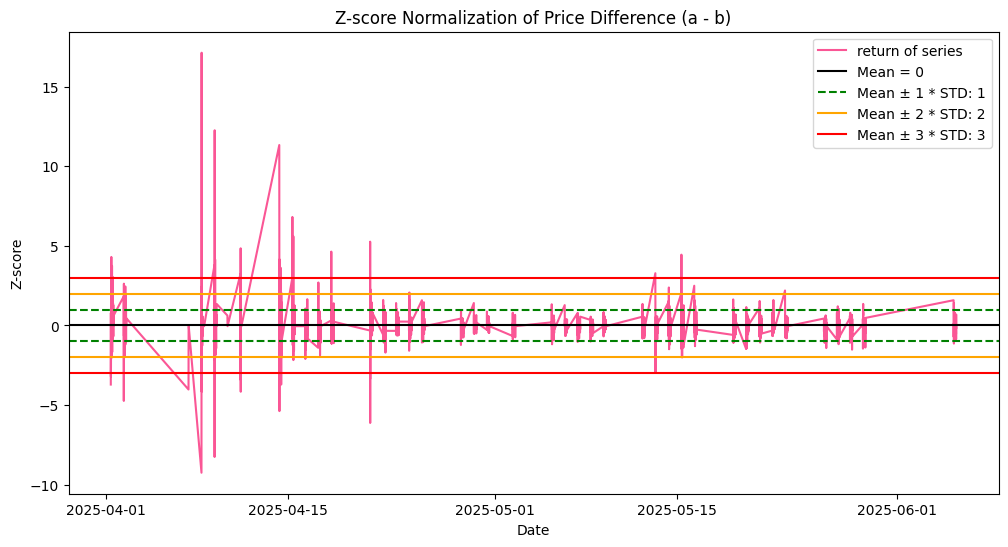

Z-score 分布统计:
大於-3: 16 个数据点
-3到-2: 12 个数据点
-2到-1: 78 个数据点
-1到1: 1936 个数据点
1到2: 69 个数据点
2到3: 18 个数据点
大於3: 22 个数据点

實際平均回歸時間：05 小時 18 分鐘 28 秒


In [573]:
def is_stationary(series, hurst_kind='price'):
    # ADF 檢驗
    adf_result = adfuller(series.dropna())
    adf_p_value = adf_result[1]
    adf_stationary = adf_p_value < 0.05  # p < 0.05 代表拒絕 H0，序列是平穩的
    adf_conclusion = "時間序列是平穩的。" if adf_stationary else "時間序列不是平穩的。"
    
    # KPSS 檢驗
    kpss_result = KPSS(series.dropna())
    kpss_p_value = kpss_result.pvalue
    kpss_stationary = kpss_p_value > 0.05  # p > 0.05 代表無法拒絕 H0，序列是平穩的
    kpss_conclusion = "時間序列是平穩的。" if kpss_stationary else "時間序列不是平穩的。"
    
    # Hurst 指數
    hurst_result_str = "數據長度不足100，跳過Hurst指數計算。"
    hurst_stationary = None  # 用於後續判斷
    if len(series.dropna()) >= 100:
        min_win, max_win = (lambda s: (
            max(50, int(len(s)*0.1)),  # min_window
            min(len(s)-100, int(len(s)*0.5)) if min(len(s)-100, int(len(s)*0.5)) > max(50, int(len(s)*0.1)) 
            else max(50, int(len(s)*0.1)) + 100
        ))(series.dropna())
        hurst_value = compute_Hc(series.dropna(), kind=hurst_kind, simplified=False, min_window=min_win, max_window=max_win)[0]
        hurst_stationary = hurst_value < 0.5  # H < 0.5 代表是均值回歸型（平穩）
        hurst_conclusion = f"Hurst 指數: {hurst_value:.4f}. 結論: {'時間序列是平穩的（均值回歸型）。' if hurst_stationary else '時間序列不是平穩的（持續趨勢型）。'}"
    
    # 顯示檢驗結果
    adf_result_str = f"ADF 檢驗 p 值: {adf_p_value:.4f}. 結論: {adf_conclusion}"
    kpss_result_str = f"KPSS 檢驗 p 值: {kpss_p_value:.4f}. 結論: {kpss_conclusion}"
    if hurst_stationary:
        hurst_result_str = f"Hurst 指數: {hurst_value:.4f}. 結論: {hurst_conclusion}"
    
    # 統一結果
    if adf_stationary and kpss_stationary and hurst_stationary:
        final_conclusion = "✅ 是平穩時間序列，可以使用均值回歸策略。"
    elif adf_stationary and not kpss_stationary:
        final_conclusion = "⚠️ 可能是趨勢型時間序列，需要差分處理。"
    else:
        final_conclusion = "❌ 不是平穩時間序列，可能是隨機漫步，不適合均值回歸策略。"
    
    # 回傳結果
    print(f"{adf_result_str}\n{kpss_result_str}\n{hurst_result_str}\n\n綜合判斷: {final_conclusion}\n\n")
    
    return adf_stationary and kpss_stationary

# 測試是否平穩
is_stationary(series1, 'random_walk')

def test_cointegration(series1, series2, significance_level=0.05):
    # 初始化結果字典
    result = {}
    # 确保两个序列具有相同的长度
    min_length = min(len(series1), len(series2))
    series1 = series1[:min_length]
    series2 = series2[:min_length]
    
    # 步驟 1：檢查序列的平穩性
    print("\n=== 序列 1 平穩性檢驗 ===")
    result['series1_stationary'] = is_stationary(series1)
    
    print("\n=== 序列 2 平穩性檢驗 ===")
    result['series2_stationary'] = is_stationary(series2)
    
    # 步驟 3：進行協整檢定
    coint_result = coint(series1, series2)
    result['test_statistic'] = coint_result[0]
    result['p_value'] = coint_result[1]
    result['is_cointegrated'] = result['p_value'] < significance_level
    result['message'] = '協整檢定完成。'
    
    # 打印協整檢定結果
    print("\n=== 協整檢定結果 ===")
    print(f"是否協整：{'是' if result['is_cointegrated'] else '否'}")
    print(f"檢定統計量：{result['test_statistic']:.4f}")
    print(f"P 值：{result['p_value']:.4f}")
    print(f"顯著性水平：{significance_level}")
    print(result['message'])
    
    # 打印最終結論
    print("\n=== 最終結論 ===")
    print(f"第一序列平穩性：{'平穩' if result['series1_stationary'] else '非平穩'}")
    print(f"第二序列平穩性：{'平穩' if result['series2_stationary'] else '非平穩'}")
    print(f"協整性：{'存在協整關係' if result['is_cointegrated'] else '無協整關係'}")
    
    return result

# test_cointegration(df_min_close_df1, df_min_close_df2)

def plot_acf_pacf(series):
    # 畫出 ACF 和 PACF 圖
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(series, lags=20, ax=axes[0])
    plot_pacf(series, lags=20, ax=axes[1])

    plt.show()

# plot_acf_pacf(df['return'])

def half_life(series, time_interval_seconds=1, max_lag=60):
    """
    穩健版半衰期計算，自動選擇有效滯後期
    """
    series_clean = series.dropna()
    if len(series_clean) < 10:
        print("數據不足，無法計算半衰期")
        return np.nan

    # lag=1
    beta = series_clean.autocorr(lag=1)
    if 0 < beta < 1:
        half_life = np.log(2) / -np.log(beta) * time_interval_seconds
        print(f"基於滯後1期自相關 (beta={beta:.4f})，半衰期: {half_life:.2f} 秒")
        # 計算建議的滾動窗口大小（單位：分鐘）
        window_min = half_life * 2 / 60
        window_max = half_life * 3 / 60
        print(f"建議滾動窗口大小（Z-score）：{window_min:.2f} - {window_max:.2f} 分鐘")
        return half_life
    else:
        print(f"滯後1階自相關 (beta={beta:.4f}) 不在(0,1)範圍，切換到ACF方法")
        
    # 方法2：使用ACF估計半衰期
    try:
        # 計算ACF，設置最大滯後數
        acf_values = acf(series_clean, nlags=max_lag, fft=False)
        
        # 找到ACF首次降到0.5以下的滯後
        half_life_lag = None
        for lag, value in enumerate(acf_values):
            if value < 0.5:
                half_life_lag = lag
                break
        
        if half_life_lag is None:
            print(f"ACF未在{max_lag}滯後內衰減到0.5以下，無法估計半衰期")
            return np.nan
        
        # 將滯後數轉換為時間單位
        half_life = half_life_lag * time_interval_seconds
        print(f"基於ACF估計，半衰期: {half_life:.2f} 秒 (滯後={half_life_lag})")
        
        # 計算建議的滾動窗口大小（單位：分鐘）
        window_min = half_life * 2 / 60
        window_max = half_life * 3 / 60
        print(f"建議滾動窗口大小（Z-score）：{window_min:.2f} - {window_max:.2f} 分鐘\n\n")
        return half_life
    
    except Exception as e:
        print(f"ACF計算失敗，錯誤訊息: {str(e)}")
        return np.nan

half_life(series1, time_interval_seconds=1800) # 第二個參數要依照分鐘計算相對應的秒數

def plot_mean(timeseries, diff_col, label='return of series'):
    plt.figure(figsize=(12, 6))

    # 计算 z-score： (值 - 均值) / 标准差
    diff_zscore = (diff_col - np.mean(diff_col)) / np.std(diff_col)

    # 绘制 z-score 标准化后的时间序列数据
    plt.plot(timeseries.index, diff_zscore, label=label, alpha=0.7, color=np.random.rand(3,))

    # 绘制均值为0的水平线
    plt.axhline(y=0, color='black', label='Mean = 0')

    # z-score 标准化后的数据标准差为1
    std_val = 1

    # 添加标准差范围的水平线
    plt.axhline(0 - 1 * std_val, color='g', linestyle='--', label=f'Mean ± 1 * STD: {round(std_val, 2)}')
    plt.axhline(0 + 1 * std_val, color='g', linestyle='--')

    plt.axhline(0 - 2 * std_val, color='orange', label=f'Mean ± 2 * STD: {round(2 * std_val, 2)}')
    plt.axhline(0 + 2 * std_val, color='orange')

    plt.axhline(0 - 3 * std_val, color='red', label=f'Mean ± 3 * STD: {round(3 * std_val, 2)}')
    plt.axhline(0 + 3 * std_val, color='red')

    plt.legend()
    plt.title('Z-score Normalization of Price Difference (a - b)')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.show()
    
    # 统计 z-score 分布
    bins = [-np.inf, -3, -2, -1, 1, 2, 3, np.inf]
    labels = ['大於-3', '-3到-2', '-2到-1', '-1到1', '1到2', '2到3', '大於3']
    
    # 计算各个区间的频数
    counts = pd.cut(diff_zscore, bins=bins, labels=labels).value_counts()

    # 打印统计结果
    print("Z-score 分布统计:")
    for label in labels:
        print(f"{label}: {counts.get(label, 0)} 个数据点")
        
    # 添加實際平均回歸時間計算
    mean = diff_col.mean()  # 使用原始數據的均值
    std = diff_col.std()    # 使用原始數據的標準差
    crossings = ((diff_col > mean + std) | (diff_col < mean - std)).astype(int)
    crossings_diff = crossings.diff().dropna()
    reversion_times = timeseries.index[1:][crossings_diff != 0]  # 確保索引對齊
    reversion_intervals = reversion_times[1:] - reversion_times[:-1]
    
    if len(reversion_intervals) > 0:
        avg_reversion_time = reversion_intervals.mean()
        total_seconds = avg_reversion_time.total_seconds()
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print("\n實際平均回歸時間：{:02.0f} 小時 {:02.0f} 分鐘 {:02.0f} 秒".format(hours, minutes, seconds))
    else:
        print("\n實際平均回歸時間：無法計算（無足夠穿越事件）")

# 使用函數繪圖，傳入價差的 z-score
plot_mean(series1, series1)

def plot_bollinger_bands(series, bollinger_bands, title="Bollinger Bands for Cointegration Spread", num_std=2):
    """
    繪製布林通道圖表，並計算超出上下軌的數據點數量
    參數:
        series: pandas.Series, 輸入的時間序列（例如 series1）
        bollinger_bands: dict, 包含均值、上軌、下軌的DataFrame
        title: str, 圖表標題
        window: int, 滾動窗口大小（默認20期，用於參考）
        num_std: float, 標準差倍數（默認2，用於參考）
    返回:
        tuple, (above_upper_count, below_lower_count): 超出上軌和下軌的數據點數量
    """
    plt.figure(figsize=(12, 6))
    
    # 繪製時間序列
    plt.plot(series.index, series, label='Spread (series1)', color='blue')
    
    # 繪製布林通道：均值、上軌、下軌
    plt.plot(series.index, bollinger_bands['mean'], label='Moving Average', color='green', linestyle='--')
    plt.plot(series.index, bollinger_bands['upper'], label='Upper Band', color='red', linestyle='-.')
    plt.plot(series.index, bollinger_bands['lower'], label='Lower Band', color='red', linestyle='-.')

    # 計算超出上下軌的數據點
    above_upper = series > bollinger_bands['upper']
    below_lower = series < bollinger_bands['lower']
    above_upper_count = above_upper.sum()
    below_lower_count = below_lower.sum()

    # 可選：標記超出上下軌的點
    above_upper_points = series[above_upper]
    below_lower_points = series[below_lower]
    plt.scatter(above_upper_points.index, above_upper_points, color='red', marker='^', label='Above Upper Band', s=100)
    plt.scatter(below_lower_points.index, below_lower_points, color='green', marker='v', label='Below Lower Band', s=100)

    # 添加標籤和圖例
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.grid(True)
    
    # 顯示圖表
    plt.tight_layout()
    plt.show()

    # 輸出統計結果
    print(f"超出上轨的数据点数量（+{num_std}倍标准差）: {above_upper_count}")
    print(f"低于下轨的数据点数量（-{num_std}倍标准差）: {below_lower_count}")
    print(f"超出布林带的总数据点数: {above_upper_count + below_lower_count}")
    print(f"超出布林带的点数百分比: {(above_upper_count + below_lower_count) / len(series) * 100:.2f}%")
    
# # 計算布林通道繪圖
# window, num_std = 30, 3
# bb = calculate_bollinger_bands(series1, window, num_std)
# plot_bollinger_bands(series1, bb, num_std=num_std)

### 配對交易

In [574]:
def generate_zscore(series, threshold, z_window, check_signal=False, convergence=True, time_filter=False):
    trade_df = pd.DataFrame({'ratio': series})
    
    # 計算滾動均值和標準差
    trade_df['rolling_mean'] = trade_df['ratio'].rolling(window=z_window).mean()
    trade_df['rolling_std'] = trade_df['ratio'].rolling(window=z_window).std()

    # 計算 Z-score
    trade_df['z_score'] = (trade_df['ratio'] - trade_df['rolling_mean']) / trade_df['rolling_std']

    if convergence:
        # 生成交易信號
        trade_df['signal'] = 0
        trade_df.loc[trade_df['z_score'] > threshold, 'signal'] = -1  # Z-score > 2，多A空B
        trade_df.loc[trade_df['z_score'] < -threshold, 'signal'] = 1  # Z-score < -2，空A多B
    else:
        # 生成交易信號
        trade_df['signal'] = 0
        trade_df.loc[trade_df['z_score'] > threshold, 'signal'] = 1  # Z-score > 2，空A多B
        trade_df.loc[trade_df['z_score'] < -threshold, 'signal'] = -1  # Z-score < -2，多A空B
    
    if check_signal:
        print(trade_df[trade_df['signal'].isin([1, -1])])
    
    if time_filter:
        # 定義時間範圍
        start_time = pd.Timestamp('2025-04-08 08:45:00')
        end_time = pd.Timestamp('2025-04-08 09:00:00')
        
        # 確保索引是 DatetimeIndex
        trade_df.index = pd.to_datetime(trade_df.index)
        
        # 篩選指定時間範圍的資料
        time_mask = (trade_df.index >= start_time) & (trade_df.index <= end_time)
        print("\nData in time range 2025-04-08 08:45:00 to 09:00:00:")
        print(trade_df[time_mask])
    
    return trade_df

def generate_bollinger_bands(series, num_std=2, window=20, check_signal=False):
    """
    基於布林通道生成開倉信號
    參數:
        series: pandas.Series, 輸入的時間序列（例如 series1）
        window: int, 滾動窗口大小（默認20期）
        num_std: float, 標準差倍數（默認2）
    返回:
        pandas.DataFrame, 包含原始序列、均值、上軌、下軌和開倉信號
    """
    # 確保 series 是 pandas.Series 並有正確索引
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    if series.index.isna().any():
        raise ValueError("Series index contains NaN values")

    trade_df = pd.DataFrame({'ratio': series})
    
    # 計算布林通道
    bollinger_bands = calculate_bollinger_bands(series, window=window, num_std=num_std)
    trade_df['rolling_mean'] = bollinger_bands['mean']
    trade_df['upper_band'] = bollinger_bands['upper']
    trade_df['lower_band'] = bollinger_bands['lower']
    trade_df['rolling_std'] = bollinger_bands['std']
    
    # 檢查 NaN 值
    if check_signal:
        print("NaN counts in trade_df:")
        print(trade_df[['ratio', 'rolling_mean', 'upper_band', 'lower_band', 'rolling_std']].isna().sum())
    
    # 生成開倉信號，忽略 NaN
    trade_df['signal'] = 0
    valid_rows = trade_df[['ratio', 'upper_band', 'lower_band']].notna().all(axis=1)
    trade_df.loc[valid_rows & (trade_df['ratio'] > trade_df['upper_band']), 'signal'] = -1
    trade_df.loc[valid_rows & (trade_df['ratio'] < trade_df['lower_band']), 'signal'] = 1
    
    trade_df['exit_signal'] = 0
    trade_df['position'] = 0
    
    # 打印交易信號
    if check_signal:
        signal_rows = trade_df[trade_df['signal'].isin([1, -1])]
        print(f"Number of trading signals: {len(signal_rows)}")
        if not signal_rows.empty:
            print("Trading signals:")
            print(signal_rows[['ratio', 'rolling_mean', 'upper_band', 'lower_band', 'signal']])
        else:
            print("No trading signals generated.")
            # 調試：打印超出上下軌的條件
            above_upper = trade_df[valid_rows & (trade_df['ratio'] > trade_df['upper_band'])]
            below_lower = trade_df[valid_rows & (trade_df['ratio'] < trade_df['lower_band'])]
            print(f"Points above upper band: {len(above_upper)}")
            print(f"Points below lower band: {len(below_lower)}")
            if not above_upper.empty:
                print("Sample points above upper band:")
                print(above_upper[['ratio', 'upper_band']].head())
            if not below_lower.empty:
                print("Sample points below lower band:")
                print(below_lower[['ratio', 'lower_band']].head())
    
    return trade_df

def find_signal(timestamp, trade_df, check_signal=False):
    # 將 timestamp 轉為 Datetime
    timestamp = pd.to_datetime(timestamp)
    
    # 確保 trade_df.index 是 DatetimeIndex
    if not isinstance(trade_df.index, pd.DatetimeIndex):
        trade_df.index = pd.to_datetime(trade_df.index)
    
    # 找到 trade_df 中時間小於等於 timestamp 的最近 K 棒
    past_signals = trade_df[trade_df.index <= timestamp]
    
    if not past_signals.empty:
        # 取最近的 K 棒（最後一行）
        closest_signal = past_signals.iloc[-1]
        signal = closest_signal['signal']
        signal_time = past_signals.index[-1]
        
        if signal != 0 and check_signal:
            print(f"當前秒資料最接近的signal資料時間 {signal_time}, 訊號: {signal}")
            
        return (signal, signal_time)
    
    # 如果沒有找到任何小於等於 timestamp 的 K 棒，返回 None
    return (None, None)

def get_tick_price(price):
    """
    根據標的股票價格，返回對應的股票期貨最小升降單位（tick size）。
    
    Args:
        price (float or int): 標的股票價格
        
    Returns:
        float: 最小升降單位（tick size）
    """
    if price < 10:
        return 0.01
    elif 10 <= price < 50:
        return 0.05
    elif 50 <= price < 100:
        return 0.1
    elif 100 <= price < 500:
        return 0.5
    elif 500 <= price < 1000:
        return 1.0
    else:  # price >= 1000
        return 5.0

def pair_trade(df, series, **params):
    z_window, bb = params.get('z_window', None), params.get('bb', None)
    commission1, commission2 = params.get('commission1', 15), params.get('commission2', 25)
    tax1, tax2 = params.get('tax1', 0.00002), params.get('tax2', 0.00002)
    tick_size1, tick_size2 = params.get('tick_size1', 10), params.get('tick_size2', 50)
    share_per_trade1, share_per_trade2  = params.get('share_per_trade1', 1), params.get('share_per_trade2', 1)
    min_margin1, min_margin2 = params.get('min_margin1', 11750), params.get('min_margin2', 58750)
    stop_ratio1, stop_ratio2 = params.get('stop_ratio1', 70), params.get('stop_ratio2', 70)
    levearge1, levearge2 = params.get('levearge1', 1000), params.get('levearge2', 1000)
    force_stop, check_signal, time_filter = params.get('force_stop', True), params.get('check_signal', False), params.get('time_filter', False)
    trade_type = params.get('trade_type', 'future')
    convergence = params.get('convergence', True)
    capital = params.get('capital', 100000)
    threshold = params.get('threshold', 2)

    if z_window:
        trade_df = generate_zscore(series, threshold, z_window, check_signal, convergence, time_filter)
    elif bb:
        trade_df = generate_bollinger_bands(series, threshold, bb, check_signal)
    
    # 初始化變數
    position = 0  # 持倉狀態：1 表示多頭，-1 表示空頭，0 表示無持倉
    entry_price1, entry_price2 = 0, 0
    stop_loss1, stop_loss2 = 0, 0
    entry_time, entry_flag, last_k_time = None, True, None
    cost_fee, entry_fee = 0, 0
    trades = []  # 用於記錄交易資訊
    
    # 遍歷 df 的每一行
    for timestamp, row in df.iterrows():
        if trade_type == 'future' or  trade_type == 'fstock':
            if capital <= min_margin1 or capital <= min_margin2:
                print("保證金已不足")
                break
        elif trade_type == 'stock':
            if capital <= 0:
                print("資金已不足")
                break

        # 現在 row 已經被更新，可以正常使用
        current_price1 = row['close_df1']
        current_price2 = row['close_df2']
        
        # 有倉位判斷是否需要平倉
        if position != 0:
            # 先檢查止損條件
            stop_triggered = False
            
            # 檢查是否到達超時平倉時間 (13:44 或 04:59)
            current_time = timestamp.time()
            
            if trade_type == 'future':
                timeout_triggered = (current_time.hour == 13 and current_time.minute == 44) or (current_time.hour == 4 and current_time.minute == 59)
            elif trade_type == 'fstock':
                timeout_triggered = (current_time.hour == 13 and current_time.minute == 45) or (current_time.hour == 4 and current_time.minute == 59)
            elif trade_type == 'stock':
                timeout_triggered = (current_time.hour == 13 and current_time.minute == 30)                
            
            if position > 0:  # 空A多B
                # 空A: 當前價格 >= 止損價格, 多B: 當前價格 <= 止損價格
                if current_price1 >= stop_loss1 or current_price2 <= stop_loss2 or (force_stop and timeout_triggered): # 止損或超時
                    if current_price1 >= stop_loss1: print(f"股票A止損")
                    elif current_price2 <= stop_loss2: print(f"股票B止損")
                    elif (force_stop and timeout_triggered): print(f"超時強制平倉")
                    
                    print(f"當前{timestamp}: 價格/止損 - A: {current_price1}/{stop_loss1:.2f}, B: {current_price2}/{stop_loss2:.2f}")

                    stop_triggered = True
                    exit_price1 = row['ask_price_df1'][0]  # 買回A平倉
                    exit_price2 = row['bid_price_df2'][0]  # 賣出B平倉
                    
                    if trade_type == 'future':
                        tax_fee1 = exit_price1 * tick_size1 * tax1 * share_per_trade1
                        tax_fee2 = exit_price2 * tick_size2 * tax2 * share_per_trade2
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = (entry_price1 - exit_price1) * tick_size1 * share_per_trade1
                        B = (exit_price2 - entry_price2) * tick_size2 * share_per_trade2
                        profit = A + B - per_trade_fee
                        
                    elif trade_type == 'fstock':
                        tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * levearge1)
                        tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * levearge2)
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = ((entry_price1 - exit_price1)) * levearge1 * share_per_trade1
                        B = ((exit_price2 - entry_price2)) * levearge2 * share_per_trade2
                        profit = A + B - per_trade_fee

                    elif trade_type == 'stock':
                        tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * levearge1)
                        tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * levearge2)
                        comm1 = round(exit_price1 * share_per_trade1 * levearge1 * commission1)
                        comm2 = round(exit_price2 * share_per_trade2 * levearge2 * commission2)
                        tax_fee1 = 0
                        tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * levearge2)
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + comm1 + comm2
                        A = ((entry_price1 - exit_price1)) * levearge1 * share_per_trade1
                        B = ((exit_price2 - entry_price2)) * levearge2 * share_per_trade2
                        profit = A + B - per_trade_fee

                    print(f"{timestamp}: 止損(空A多B=>買A賣B)，價格1: {exit_price1}, 價格2: {exit_price2}, A獲利: {A}, B獲利: {B}, 單次交易總成本: {per_trade_fee:.2f}, 盈虧: {profit}")

            elif position < 0:  # 多A空B
                # 多A: 當前價格 <= 止損價格, 空B: 當前價格 >= 止損價格
                if current_price1 <= stop_loss1 or current_price2 >= stop_loss2 or (force_stop and timeout_triggered): # 止損或超時
                    if current_price1 <= stop_loss1: print(f"股票A止損")
                    elif current_price2 >= stop_loss2: print(f"股票B止損")
                    elif (force_stop and timeout_triggered): print(f"超時強制平倉")
                    
                    print(f"當前{timestamp}: 價格/止損 - A: {current_price1}/{stop_loss1}, B: {current_price2}/{stop_loss2}")

                    stop_triggered = True
                    exit_price1 = row['bid_price_df1'][0] # 賣出A平倉
                    exit_price2 = row['ask_price_df2'][0] # 買回B平倉
                    
                    if trade_type == 'future':
                        tax_fee1 = exit_price1 * tick_size1 * tax1 * share_per_trade1
                        tax_fee2 = exit_price2 * tick_size2 * tax2 * share_per_trade2
                        cost_fee += tax_fee1 + tax_fee2 + commission1 + commission2
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = (exit_price1 - entry_price1) * tick_size1 * share_per_trade1
                        B = (entry_price2 - exit_price2) * tick_size2 * share_per_trade2
                        profit = A + B - per_trade_fee
                        
                    elif trade_type == 'fstock':
                        tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * levearge1)
                        tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * levearge2)
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = ((exit_price1 - entry_price1)) * levearge1 * share_per_trade1
                        B = ((entry_price2 - exit_price2)) * levearge2 * share_per_trade2
                        profit = A + B - per_trade_fee
                        
                    elif trade_type == 'stock':
                        comm1 = round(exit_price1 * share_per_trade1 * levearge1 * commission1)
                        comm2 = round(exit_price2 * share_per_trade2 * levearge2 * commission2)
                        tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * levearge1)
                        tax_fee2 = 0
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + comm1 + comm2
                        
                        A = ((exit_price1 - entry_price1)) * levearge1 * share_per_trade1
                        B = ((entry_price2 - exit_price2)) * levearge2 * share_per_trade2
                        profit = A + B - per_trade_fee
                    
                    print(f"{timestamp}: 止損(多A空B=>賣A買B)，價格1: {exit_price1}, 價格2: {exit_price2}, A獲利: {A}, B獲利: {B}, 單次交易總成本: {per_trade_fee:.2f}, 盈虧: {profit}")

            # 如果觸發止損，記錄交易並重置
            if stop_triggered:
                capital += profit
                print(f"當前交易後總資產: {capital:.2f}")
                trades.append({
                    'timestamp': timestamp,
                    'entry_time': entry_time,
                    'exit_time': timestamp,
                    'entry_price1': entry_price1,
                    'exit_price1': exit_price1,
                    'entry_price2': entry_price2,
                    'exit_price2': exit_price2,
                    'total_fee': cost_fee,
                    'capital': capital,
                    'net_profit_loss': profit,
                    'position': position,
                    'type': 'force_close' if (force_stop and timeout_triggered) else 'stop_loss'
                })
                position, entry_fee = 0, 0
                entry_price1, entry_price2 = 0, 0
                stop_loss1, stop_loss2 = 0, 0
                entry_time, entry_flag = None, False
                print('------- 單次交易結束 -------\n')
                continue
            
            # 如果是統計套利
            if z_window and convergence:
                # 檢查是否回歸平倉
                current_z_score, _ = find_signal(timestamp, trade_df)

                if not current_z_score:
                    continue
                
                # 沒止損檢查是否滿足平倉條件
                if abs(current_z_score) < 0.1:  # Z-score 接近 0 時平倉
                    if position > 0: # 空A多B
                        print(f"當前價格 - A: {current_price1}, B: {current_price2}")

                        exit_price1 = row['ask_price_df1'][0]
                        exit_price2 = row['bid_price_df2'][0]

                        if trade_type == 'future':
                            tax_fee1 = exit_price1 * tick_size1 * tax1 * share_per_trade1
                            tax_fee2 = exit_price2 * tick_size2 * tax2 * share_per_trade2
                            per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                            A = (entry_price1 - exit_price1) * tick_size1 * share_per_trade1
                            B = (exit_price2 - entry_price2) * tick_size2 * share_per_trade2
                            profit = A + B - per_trade_fee

                        elif trade_type == 'fstock':
                            tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * levearge1)
                            tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * levearge2)
                            per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                            A = ((entry_price1 - exit_price1)) * levearge1 * share_per_trade1
                            B = ((exit_price2 - entry_price2)) * levearge2 * share_per_trade2
                            profit = A + B - per_trade_fee
                            
                        elif trade_type == 'stock':
                            commission1 = round(exit_price1 * share_per_trade1 * levearge1 * commission1)
                            commission2 = round(exit_price2 * share_per_trade2 * levearge2 * commission2)
                            tax_fee1 = 0
                            tax_fee2 = round(entry_price2 * tax2 * share_per_trade2 * levearge2)
                            per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                            A = ((entry_price1 - exit_price1)) * levearge1 * share_per_trade1
                            B = ((exit_price2 - entry_price2)) * levearge2 * share_per_trade2
                            profit = A + B - per_trade_fee
                            
                        print(f"{timestamp}: 平倉(空A多B=>買A賣B)，價格1: {exit_price1}, 價格2: {exit_price2}, A獲利: {A}, B獲利: {B}, 單次交易總成本: {per_trade_fee:.2f}, 盈虧: {profit}")

                    elif position < 0: # 多A空B
                        print(f"當前價格 - A: {current_price1}, B: {current_price2}")

                        exit_price1 = row['bid_price_df1'][0]
                        exit_price2 = row['ask_price_df2'][0]

                        if trade_type == 'future':
                            tax_fee1 = exit_price1 * tick_size1 * tax1 * share_per_trade1
                            tax_fee2 = exit_price2 * tick_size2 * tax2 * share_per_trade2
                            cost_fee += tax_fee1 + tax_fee2 + commission1 + commission2
                            per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                            A = (exit_price1 - entry_price1) * tick_size1 * share_per_trade1
                            B = (entry_price2 - exit_price2) * tick_size2 * share_per_trade2
                            profit = A + B - per_trade_fee

                        elif trade_type == 'fstock':
                            tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * 1000)
                            tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * 1000)
                            per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                            A = ((exit_price1 - entry_price1) / tick_size1) * levearge1 * share_per_trade1
                            B = ((entry_price2 - exit_price2) / tick_size2) * levearge2 * share_per_trade2
                            profit = A + B - per_trade_fee
                        
                        elif trade_type == 'stock':
                            commission1 = round(exit_price1 * share_per_trade1 * levearge1 * commission1)
                            commission2 = round(exit_price2 * share_per_trade2 * levearge2 * commission2)
                            tax_fee1 = round(entry_price1 * tax1 * share_per_trade1 * levearge1)
                            tax_fee2 = 0
                            per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                            A = ((exit_price1 - entry_price1)) * levearge1 * share_per_trade1
                            B = ((entry_price2 - exit_price2)) * levearge2 * share_per_trade2
                            profit = A + B - per_trade_fee
                        
                        print(f"{timestamp}: 平倉(多A空B=>賣A買B)，價格1: {exit_price1}, 價格2: {exit_price2}, A獲利: {A}, B獲利: {B}, 單次交易總成本: {per_trade_fee:.2f}, 盈虧: {profit}")

                    capital += profit
                    print(f"當前交易後總資產: {capital:.2f}")
                    trades.append({
                        'timestamp': timestamp,
                        'entry_time': entry_time,
                        'exit_time': timestamp,
                        'entry_price1': entry_price1,
                        'exit_price1': exit_price1,
                        'entry_price2': entry_price2,
                        'exit_price2': exit_price2,
                        'total_fee': cost_fee,
                        'capital': capital,
                        'net_profit_loss': profit,
                        'position': position,
                        'type': 'close'  # 添加出場原因
                    })

                    position, entry_fee = 0, 0  # 平倉後重置持倉狀態
                    entry_price1, entry_price2 = 0, 0
                    stop_loss1, stop_loss2 = 0, 0
                    entry_time = None
                    print('------- 單次交易結束 -------\n')
                    continue
        
            # 如果是布林通道
            elif bb:
                signal = find_signal(timestamp, trade_df, k_period=f"{k_time}min")
                if signal == 0: continue
                
                current_ratio = trade_df.at[timestamp, 'ratio']
                current_mean = trade_df.at[timestamp, 'rolling_mean']
                
                if position > 0 and current_ratio >= current_mean:
                    trade_df.at[timestamp, 'exit_signal'] = -1
                    trade_df.at[timestamp, 'position'] = 0
                    print(f"當前價格 - A: {current_price1}, B: {current_price2}")
                    
                    exit_price1 = row['ask_price_df1'][0]
                    exit_price2 = row['bid_price_df2'][0]

                    if trade_type == 'future':
                        tax_fee1 = exit_price1 * tick_size1 * tax1 * share_per_trade1
                        tax_fee2 = exit_price2 * tick_size2 * tax2 * share_per_trade2
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = (entry_price1 - exit_price1) * tick_size1 * share_per_trade1
                        B = (exit_price2 - entry_price2) * tick_size2 * share_per_trade2
                        profit = A + B - per_trade_fee

                    elif trade_type == 'fstock':
                        tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * levearge1)
                        tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * levearge2)
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = ((entry_price1 - exit_price1)) * levearge1 * share_per_trade1
                        B = ((exit_price2 - entry_price2)) * levearge2 * share_per_trade2
                        profit = A + B - per_trade_fee

                    print(f"{timestamp}: 平倉(空A多B=>買A賣B)，價格1: {exit_price1}, 價格2: {exit_price2}, A獲利: {A}, B獲利: {B}, 單次交易總成本: {per_trade_fee:.2f}, 盈虧: {profit}")

                elif position < 0 and current_ratio <= current_mean:
                    trade_df.at[timestamp, 'exit_signal'] = 1
                    trade_df.at[timestamp, 'position'] = 0
                    
                    print(f"當前價格 - A: {current_price1}, B: {current_price2}")
                    
                    exit_price1 = row['bid_price_df1'][0]
                    exit_price2 = row['ask_price_df2'][0]

                    if trade_type == 'future':
                        tax_fee1 = exit_price1 * tick_size1 * tax1 * share_per_trade1
                        tax_fee2 = exit_price2 * tick_size2 * tax2 * share_per_trade2
                        cost_fee += tax_fee1 + tax_fee2 + commission1 + commission2
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = (exit_price1 - entry_price1) * tick_size1 * share_per_trade1
                        B = (entry_price2 - exit_price2) * tick_size2 * share_per_trade2
                        profit = A + B - per_trade_fee

                    elif trade_type == 'fstock':
                        tax_fee1 = round(exit_price1 * tax1 * share_per_trade1 * 1000)
                        tax_fee2 = round(exit_price2 * tax2 * share_per_trade2 * 1000)
                        per_trade_fee = entry_fee + tax_fee1 + tax_fee2 + commission1 + commission2
                        A = ((exit_price1 - entry_price1) / tick_size1) * levearge1 * share_per_trade1
                        B = ((entry_price2 - exit_price2) / tick_size2) * levearge2 * share_per_trade2
                        profit = A + B - per_trade_fee
                     
                    print(f"{timestamp}: 平倉(多A空B=>賣A買B)，價格1: {exit_price1}, 價格2: {exit_price2}, A獲利: {A}, B獲利: {B}, 單次交易總成本: {per_trade_fee:.2f}, 盈虧: {profit}")
                
                else:
                    trade_df.at[timestamp, 'position'] = position
                    continue
                
                capital += profit
                print(f"當前交易後總資產: {capital:.2f}")
                trades.append({
                    'timestamp': timestamp,
                    'entry_time': entry_time,
                    'exit_time': timestamp,
                    'entry_price1': entry_price1,
                    'exit_price1': exit_price1,
                    'entry_price2': entry_price2,
                    'exit_price2': exit_price2,
                    'total_fee': cost_fee,
                    'capital': capital,
                    'net_profit_loss': profit,
                    'position': position,
                    'type': 'close'
                })
                position, entry_fee = 0, 0
                entry_price1, entry_price2 = 0, 0
                stop_loss1, stop_loss2 = 0, 0
                entry_time = None
                print('------- 單次交易結束 -------\n')
                continue
    
        # 無艙位進行統計套利
        if position == 0:
            signal, new_k_time = find_signal(timestamp, trade_df, check_signal=check_signal)

            if last_k_time != new_k_time:
                entry_flag = True
                last_k_time = new_k_time
            
            if not signal:
                continue

            if not entry_flag:
                continue
            
            if signal == 1: # 空A多B
                position = 1
                entry_time = timestamp
                entry_price1 = row['bid_price_df1'][0]
                entry_price2 = row['ask_price_df2'][0]

                # 設置止損價格
                if trade_type == 'future':
                    stop_loss1 = entry_price1 + stop_ratio1   # 空A: 進場價 + 止損點數
                    stop_loss2 = entry_price2 - stop_ratio2   # 多B: 進場價 - 止損點數
                    tax_fee1 = entry_price1 * tick_size1 * tax1 * share_per_trade1
                    tax_fee2 = entry_price2 * tick_size2 * tax2 * share_per_trade2
                    total_commission = commission1 + commission2
                    
                elif trade_type == 'fstock':
                    tick_size1 = get_tick_price(entry_price1)
                    tick_size2 = get_tick_price(entry_price2)
                    stop_loss1 = round((entry_price1 * (1 + stop_ratio1)) / tick_size1) * tick_size1
                    stop_loss2 = round((entry_price2 * (1 - stop_ratio2)) / tick_size2) * tick_size2
                    tax_fee1 = round(entry_price1 * tax1 * share_per_trade1 * levearge1)
                    tax_fee2 = round(entry_price2 * tax2 * share_per_trade2 * levearge2)
                    total_commission = commission1 + commission2
                
                elif trade_type == 'stock':
                    tick_size1 = get_tick_price(entry_price1)
                    tick_size2 = get_tick_price(entry_price2)
                    stop_loss1 = round((entry_price1 * (1 + stop_ratio1)) / tick_size1) * tick_size1
                    stop_loss2 = round((entry_price2 * (1 - stop_ratio2)) / tick_size2) * tick_size2
                    comm1 = round(entry_price1 * share_per_trade1 * levearge1 * commission1)
                    comm2 = round(entry_price2 * share_per_trade2 * levearge2 * commission2)
                    tax_fee1 = round(entry_price1 * tax1 * share_per_trade1 * levearge1)
                    tax_fee2 = 0
                    total_commission = comm1 + comm2
                
                entry_fee = tax_fee1 + tax_fee2 + total_commission
                cost_fee += entry_fee

                print(f"{timestamp}: 執行空A多B操作，進場價格1: {entry_price1}, 進場價格2: {entry_price2}")
                print(f"止損設置 - A: {stop_loss1:.2f}, B: {stop_loss2:.2f}, 進場成本: {entry_fee:.2f}\n")
                
            elif signal == -1: # 多A空B
                position = -1
                entry_time = timestamp
                entry_price1 = row['ask_price_df1'][0]
                entry_price2 = row['bid_price_df2'][0]

                # 設置止損價格
                if trade_type == 'future':
                    stop_loss1 = entry_price1 - stop_ratio1   # 多A: 進場價 - 止損點數
                    stop_loss2 = entry_price2 + stop_ratio2   # 空B: 進場價 + 止損點數
                    tax_fee1 = entry_price1 * tick_size1 * tax1 * share_per_trade1
                    tax_fee2 = entry_price2 * tick_size2 * tax2 * share_per_trade2
                    total_commission = commission1 + commission2
                    
                elif trade_type == 'fstock':
                    tick_size1 = get_tick_price(entry_price1)
                    tick_size2 = get_tick_price(entry_price2)
                    stop_loss1 = round((entry_price1 * (1 - stop_ratio1)) / tick_size1) * tick_size1
                    stop_loss2 = round((entry_price2 * (1 + stop_ratio2)) / tick_size2) * tick_size2
                    tax_fee1 = round(entry_price1 * tax1 * share_per_trade1 * levearge1)
                    tax_fee2 = round(entry_price2 * tax2 * share_per_trade2 * levearge2)
                    total_commission = commission1 + commission2
                    
                elif trade_type == 'stock':
                    tick_size1 = get_tick_price(entry_price1)
                    tick_size2 = get_tick_price(entry_price2)
                    stop_loss1 = round((entry_price1 * (1 - stop_ratio1)) / tick_size1) * tick_size1
                    stop_loss2 = round((entry_price2 * (1 + stop_ratio2)) / tick_size2) * tick_size2
                    comm1 = round(entry_price1 * share_per_trade1 * levearge1 * commission1)
                    comm2 = round(entry_price2 * share_per_trade2 * levearge2 * commission2)
                    tax_fee1 = 0
                    tax_fee2 = round(entry_price2 * tax2 * share_per_trade2 * levearge2)
                    total_commission = comm1 + comm2
                
                entry_fee = tax_fee1 + tax_fee2 + total_commission
                cost_fee += entry_fee

                print(f"{timestamp}: 執行多A空B操作，進場價格1: {entry_price1}, 進場價格2: {entry_price2}")
                print(f"止損設置 - A: {stop_loss1:.2f}, B: {stop_loss2:.2f}, 進場成本: {entry_fee:.2f}\n")

    # 繪圖參考
    if params.get('plot1'):
        plt.plot(trade_df['z_score'], label=f'z_window={z_window}')
        plt.axhline(y=2, color='r', linestyle='--')
        plt.axhline(y=-2, color='r', linestyle='--')
        plt.legend()
        plt.show()
        
        # 打印信號分佈
        print("信號分佈：")
        print(trade_df['signal'].value_counts())

        # 假设 trade_df 的索引是时间戳
        for signal_value in trade_df['signal'].unique():
            signal_times = trade_df.index[trade_df['signal'] == signal_value].tolist()
            print(f"信号值 {signal_value} 出现的时间点")
            print(signal_times)
    
    # 績效檢測
    if trades:
        performance = analyze(trade_result=trades, is_plot=params.get('plot3'))

        # 打印分析结果
        print(f"\n净盈亏：{performance['net_profit_loss']:.2f}")
        print(f"交易後總資產：{performance['capital']:.2f}")
        print(f"獲利次數：{performance['win_count']:.2f}")
        print(f"虧損次數：{performance['loss_count']:.2f}")
        print(f"胜率：{performance['win_rate']*100:.2f}%")
        print(f"最大回撤：{performance['max_drawdown']:.2f}")
        print(f"年化回报：{performance['annualized_return']:.2f}")
        print(f"夏普比率：{performance['sharpe_ratio']:.2f}")
        print(f"风暴比：{performance['sterling_ratio']:.2f}")
        print(f"总交易次数：{performance['total_trades']}")
        print(f"总手续费和税费：{cost_fee:.2f}")
            
        # 打印收益分布的肥尾與偏態檢驗結果
        print("收益分布分析結論：")
        print(f" - 偏態值：{performance['skewness']:.2f}")
        print(f" - 峭度：{performance['kurtosis']:.2f}")
        print(f" - 綜合分析：{performance['overall_conclusion']}\n")
        print(f"最终总资产：{capital:.2f}\n")
            
        # 打印每个交易类型的分析结果
        print("按盘面类型分析结果：")
        for trade_type, stats in performance['type_performance'].items():
            print(f"\n类型：{trade_type}")
            print(f" - 总交易次数：{stats['total_trades']}")
            print(f" - 净盈亏：{stats['total_profit_loss']:.2f}")
            print(f" - 获利次数：{stats['win_count']}")
            print(f" - 亏损次数：{stats['loss_count']}")
            print(f" - 胜率：{stats['win_rate']*100:.2f}%")
            print(f" - 获利时间点：{stats['profit_timestamps']}")
            print(f" - 亏损时间点：{stats['loss_timestamps']}")
            
    else:
        print("\n沒有交易結果可分析。")

### 國泰金(CKFR)/富邦金(CEFR)

In [261]:
params = {
    'k_time': K_time,
    'z_window': 20,
    'threshold': 2,
    'commission1': 50,
    'tax1': 0.00002,
    'levearge1': 2000,
    'share_per_trade1': 1,
    'tick_size1': 0.1,
    'commission2':50,
    'tax2': 0.00002,
    'share_per_trade2': 1,
    'tick_size2': 0.1,
    'levearge2': 2000, # 一口合約對應的槓桿股數
    'capital': 60000,
    'min_margin1': 24000,
    'min_margin2': 17820,
    'stop_ratio1': 0.025, # 止損
    'stop_ratio2': 0.025, # 止損
    'trade_type': 'fstock',
    'plot1': False,
    'check_signal': False,
    'force_stop': False,
    'convergence': True
}

pair_trade(df, series1, **params)

2025-04-08 09:01:56: 執行多A空B操作，進場價格1: 76.2, 進場價格2: 53.7
止損設置 - A: 74.30, B: 55.00, 進場成本: 105.00

股票A止損
當前2025-04-09 12:08:08: 價格/止損 - A: 73.9/74.3, B: 50.4/55.0
2025-04-09 12:08:08: 止損(多A空B=>賣A買B)，價格1: 73.9, 價格2: 50.5, A獲利: -4599.9999999999945, B獲利: 6400.0000000000055, 單次交易總成本: 210.00, 盈虧: 1590.000000000011
當前交易後總資產: 61590.00
------- 單次交易結束 -------

2025-04-17 09:00:20: 執行空A多B操作，進場價格1: 79.7, 進場價格2: 54.2
止損設置 - A: 81.70, B: 52.80, 進場成本: 105.00

股票B止損
當前2025-04-22 09:04:15: 價格/止損 - A: 77.4/81.70, B: 52.5/52.80
2025-04-22 09:04:15: 止損(空A多B=>買A賣B)，價格1: 77.6, 價格2: 52.4, A獲利: 4200.000000000017, B獲利: -3600.0000000000086, 單次交易總成本: 210.00, 盈虧: 390.00000000000864
當前交易後總資產: 61980.00
------- 單次交易結束 -------

2025-04-22 09:05:46: 執行空A多B操作，進場價格1: 77.1, 進場價格2: 52.4
止損設置 - A: 79.00, B: 51.10, 進場成本: 105.00

股票A止損
當前2025-04-24 09:53:55: 價格/止損 - A: 79.0/79.00, B: 53.5/51.10
2025-04-24 09:53:55: 止損(空A多B=>買A賣B)，價格1: 79.2, 價格2: 53.5, A獲利: -4200.000000000017, B獲利: 2200.0000000000027, 單次交易總成本: 210.00, 盈虧: -2210

### 萬海(QXFR1)/陽明(DAFR1)

In [575]:
params = {
    'k_time': K_time,
    'z_window': 20,
    'threshold': 2,
    'commission1': 50,
    'tax1': 0.00002,
    'levearge1': 2000,
    'share_per_trade1': 1,
    'tick_size1': 0.5,
    'commission2': 50,
    'tax2': 0.00002,
    'share_per_trade2': 1,
    'tick_size2': 0.1,
    'levearge2': 2000,
    'capital': 100000,
    'min_margin1': 41310,
    'min_margin2': 31995,
    'stop_ratio1': 0.025, # 止損
    'stop_ratio2': 0.03, # 止損
    'trade_type': 'fstock',
    'plot1': False,
    'check_signal': False,
    'force_stop': False,
    'convergence': True
}

pair_trade(df, series1, **params)

2025-04-01 11:12:21: 執行多A空B操作，進場價格1: 80.4, 進場價格2: 77.1
止損設置 - A: 78.40, B: 79.40, 進場成本: 106.00

股票A止損
當前2025-04-08 08:58:42: 價格/止損 - A: 67.9/78.4, B: 63.7/79.4
2025-04-08 08:58:42: 止損(多A空B=>賣A買B)，價格1: 67.9, 價格2: 63.8, A獲利: -25000.0, B獲利: 26599.999999999993, 單次交易總成本: 212.00, 盈虧: 1387.9999999999927
當前交易後總資產: 101388.00
------- 單次交易結束 -------

2025-04-08 09:00:09: 執行多A空B操作，進場價格1: 68.1, 進場價格2: 63.8
止損設置 - A: 66.40, B: 65.70, 進場成本: 106.00

股票A止損
當前2025-04-09 08:50:22: 價格/止損 - A: 64.8/66.4, B: 59.7/65.7
2025-04-09 08:50:22: 止損(多A空B=>賣A買B)，價格1: 64.6, 價格2: 59.8, A獲利: -7000.0, B獲利: 8000.0, 單次交易總成本: 211.00, 盈虧: 789.0
當前交易後總資產: 102177.00
------- 單次交易結束 -------

2025-04-09 09:00:05: 執行空A多B操作，進場價格1: 63.8, 進場價格2: 59.6
止損設置 - A: 65.40, B: 57.80, 進場成本: 105.00

股票A止損
當前2025-04-09 09:13:32: 價格/止損 - A: 65.9/65.40, B: 61.4/57.80
2025-04-09 09:13:32: 止損(空A多B=>買A賣B)，價格1: 66.0, 價格2: 61.4, A獲利: -4400.0000000000055, B獲利: 3599.9999999999945, 單次交易總成本: 210.00, 盈虧: -1010.0000000000109
當前交易後總資產: 101167.00
------- 單次

### 國泰金(CKFR)/新光金(DDFR)

In [408]:
params = {
    'k_time': K_time,
    'z_window': 15,
    'threshold': 2,
    'commission1': 50,
    'tax1': 0.00002,
    'levearge1': 2000,
    'share_per_trade1': 1,
    'tick_size1': 0.1,
    'commission2':50,
    'tax2': 0.00002,
    'share_per_trade2': 1,
    'tick_size2': 0.05,
    'levearge2': 2000, # 一口合約對應的槓桿股數
    'capital': 60000,
    'min_margin1': 24000,
    'min_margin2': 4000,
    'stop_ratio1': 0.025, # 止損
    'stop_ratio2': 0.025, # 止損
    'trade_type': 'fstock',
    'plot1': False,
    'check_signal': False,
    'force_stop': False,
    'convergence': True
}

pair_trade(df, series1, **params)

2025-04-14 09:37:35: 執行空A多B操作，進場價格1: 54.3, 進場價格2: 10.9
止損設置 - A: 55.70, B: 10.65, 進場成本: 102.00

股票A止損
當前2025-04-29 13:41:36: 價格/止損 - A: 55.7/55.70, B: 11.6/10.65
2025-04-29 13:41:36: 止損(空A多B=>買A賣B)，價格1: 55.7, 價格2: 11.6, A獲利: -2800.0000000000114, B獲利: 1399.9999999999986, 單次交易總成本: 204.00, 盈虧: -1604.0000000000127
當前交易後總資產: 58396.00
------- 單次交易結束 -------

2025-04-30 09:15:43: 執行多A空B操作，進場價格1: 58.0, 進場價格2: 11.65
止損設置 - A: 56.50, B: 11.95, 進場成本: 102.00

股票A止損
當前2025-05-05 08:52:38: 價格/止損 - A: 56.3/56.5, B: 11.55/11.950000000000001
2025-05-05 08:52:38: 止損(多A空B=>賣A買B)，價格1: 56.3, 價格2: 11.6, A獲利: -3400.0000000000055, B獲利: 100.00000000000142, 單次交易總成本: 204.00, 盈虧: -3504.000000000004
當前交易後總資產: 54892.00
------- 單次交易結束 -------

2025-05-05 09:48:28: 執行多A空B操作，進場價格1: 53.8, 進場價格2: 11.2
止損設置 - A: 52.50, B: 11.50, 進場成本: 102.00

股票B止損
當前2025-05-16 09:07:04: 價格/止損 - A: 60.5/52.5, B: 11.55/11.5
2025-05-16 09:07:04: 止損(多A空B=>賣A買B)，價格1: 60.4, 價格2: 11.55, A獲利: 13200.000000000004, B獲利: -700.0000000000028, 單次交易總成本

### 大小金融指數

In [438]:
params = {
    'k_time': K_time,
    'z_window': 10,
    'threshold': 2,
    'commission1': 15,
    'tax1': 0.00002,
    'share_per_trade1': 1,
    'tick_size1': 100,
    'commission2':15,
    'tax2': 0.00002,
    'share_per_trade2': 1,
    'tick_size2': 25,
    'capital': 150000,
    'min_margin1': 115000,
    'min_margin2': 28750,
    'stop_ratio1': 50, # 止損
    'stop_ratio2': 150, # 止損
    'plot1': False,
    'check_signal': False,
    'force_stop': False,
}

pair_trade(df, series1, **params)

2025-01-07 12:42:06: 執行空A多B操作，進場價格1: 2131.4, 進場價格2: 2132.4
止損設置 - A: 2181.40, B: 1982.40, 進場成本: 35.33

股票A止損
當前2025-02-26 12:51:53: 價格/止損 - A: 2181.8/2181.40, B: 2180.6/1982.40
2025-02-26 12:51:53: 止損(空A多B=>買A賣B)，價格1: 2181.4, 價格2: 2179.4, A獲利: -5000.0, B獲利: 1175.0, 單次交易總成本: 70.78, 盈虧: -3895.7815
當前交易後總資產: 146104.22
------- 單次交易結束 -------

2025-03-03 13:26:51: 執行多A空B操作，進場價格1: 2181.0, 進場價格2: 2180.0
止損設置 - A: 2131.00, B: 2330.00, 進場成本: 35.45

股票A止損
當前2025-03-11 08:48:49: 價格/止損 - A: 2125.0/2131.0, B: 2125.4/2330.0
2025-03-11 08:48:49: 止損(多A空B=>賣A買B)，價格1: 2125.0, 價格2: 2129.8, A獲利: -5600.0, B獲利: 1254.9999999999955, 單次交易總成本: 70.77, 盈虧: -4415.766900000004
當前交易後總資產: 141688.45
------- 單次交易結束 -------

2025-03-11 10:48:47: 執行空A多B操作，進場價格1: 2117.0, 進場價格2: 2118.8
止損設置 - A: 2167.00, B: 1968.80, 進場成本: 35.29

股票A止損
當前2025-03-25 09:43:23: 價格/止損 - A: 2167.0/2167.00, B: 2166.6/1968.80
2025-03-25 09:43:23: 止損(空A多B=>買A賣B)，價格1: 2167.0, 價格2: 2165.6, A獲利: -5000.0, B獲利: 1169.9999999999932, 單次交易總成本: 70.71, 盈虧: -3

### 微小台

In [543]:
params = { # 45min(bias)
    'k_time': K_time,
    'z_window': 20,
    'threshold': 2,
    'commission1': 15,
    'tax1': 0.00002,
    'share_per_trade1': 1,
    'tick_size1': 10,
    'commission2':25,
    'tax2': 0.00002,
    'share_per_trade2': 1,
    'tick_size2': 50,
    'capital': 100000,
    'min_margin1': 11750,
    'min_margin2': 58750,
    'stop_ratio1': 250, # 止損
    'stop_ratio2': 50, # 止損
    'force_stop': False,
    'plot1': False
}

pair_trade(df, series1, **params)

2025-04-03 03:45:00: 執行多A空B操作，進場價格1: 21482.0, 進場價格2: 21480.0
止損設置 - A: 21232.00, B: 21530.00, 進場成本: 65.78

股票B止損
當前2025-04-03 04:13:26: 價格/止損 - A: 21537.0/21232.0, B: 21530.0/21530.0
2025-04-03 04:13:26: 止損(多A空B=>賣A買B)，價格1: 21535.0, 價格2: 21523.0, A獲利: 530.0, B獲利: -2150.0, 單次交易總成本: 131.61, 盈虧: -1751.6064000000001
當前交易後總資產: 98248.39
------- 單次交易結束 -------

2025-04-03 04:30:00: 執行多A空B操作，進場價格1: 21168.0, 進場價格2: 21195.0
止損設置 - A: 20918.00, B: 21245.00, 進場成本: 65.43

股票A止損
當前2025-04-03 04:44:27: 價格/止損 - A: 20912.0/20918.0, B: 20914.0/21245.0
2025-04-03 04:44:27: 止損(多A空B=>賣A買B)，價格1: 20912.0, 價格2: 20918.0, A獲利: -2560.0, B獲利: 13850.0, 單次交易總成本: 130.53, 盈虧: 11159.471
當前交易後總資產: 109407.86
------- 單次交易結束 -------

2025-04-08 03:00:00: 執行空A多B操作，進場價格1: 18352.0, 進場價格2: 18355.0
止損設置 - A: 18602.00, B: 18305.00, 進場成本: 62.03

股票A止損
當前2025-04-08 08:45:00: 價格/止損 - A: 18625.0/18602.00, B: 18604.0/18305.00
2025-04-08 08:45:00: 止損(空A多B=>買A賣B)，價格1: 18603.0, 價格2: 18600.0, A獲利: -2510.0, B獲利: 12250.0, 單次交易總成本: 124.35,

## 輔助判斷函數工具代碼

### 期貨停損計算

In [ ]:
def calculate_stop_loss(
    max_loss: float,
    entry_price: float,
    point_value: float,
    commission: float,
    tax_rate: float,
    position_type: str,
    commission_type: str = "single",
    initial_margin: float = None,
    maintenance_margin: float = None,
    consider_margin: bool = False,
    verbose: bool = False,
) -> int:
    """
    計算期貨交易停損點數，考慮手續費、稅金、保證金等約束

    Args:
        max_loss (float): 最大可接受虧損（元）
        entry_price (float): 進場價（指數點數）
        point_value (float): 每點價值（元）
        commission (float): 手續費（單邊或雙邊，由commission_type決定）
        tax_rate (float): 交易稅率（基於平倉價的比例）
        position_type (str): 倉位類型 'long'（多倉）或 'short'（空倉）
        commission_type (str): 手續費類型 'single'（單邊）或 'both'（雙邊）
        initial_margin (float): 初始保證金（元，需與maintenance_margin一起提供）
        maintenance_margin (float): 維持保證金（元，需與initial_margin一起提供）
        consider_margin (bool): 是否考慮保證金維持率限制
        verbose (bool): 是否輸出詳細計算過程

    Returns:
        int: 停損點數（整數，無條件捨去）
    """
    # --- 參數驗證 ---
    if position_type not in ["long", "short"]:
        raise ValueError("position_type 必須是 'long' 或 'short'")
    if commission_type not in ["single", "both"]:
        raise ValueError("commission_type 必須是 'single' 或 'both'")
    if consider_margin and (initial_margin is None or maintenance_margin is None):
        raise ValueError("考慮保證金時需提供 initial_margin 和 maintenance_margin")

    # --- 手續費計算 ---
    total_commission = commission * 2 if commission_type == "single" else commission

    # --- 保證金限制計算 ---
    actual_max_loss = max_loss
    if consider_margin:
        margin_limit = initial_margin - maintenance_margin
        actual_max_loss = min(max_loss, margin_limit)
        if verbose:
            print(f"保證金限制下最大允許虧損: {actual_max_loss}元")

            risk_lower_bound = initial_margin * 0.10
            risk_upper_bound = initial_margin * 0.15

            print("\n[保證金風險分析]")
            print(f"保證金初始值: {initial_margin}元")
            print(f"建議風險範圍: {risk_lower_bound:.2f}元 ~ {risk_upper_bound:.2f}元")
            print(f"當前允許最大虧損: {max_loss}元")

            if max_loss < risk_lower_bound:
                print("風險偏低，可能無法容忍短期波動。")
            elif max_loss > risk_upper_bound:
                print("風險偏高，需謹慎管理倉位。")
            else:
                print("風險處於合理範圍內。")

    # --- 核心公式計算 ---
    try:
        numerator = actual_max_loss - total_commission - entry_price * point_value * tax_rate
        denominator = (
            point_value * (1 - tax_rate)
            if position_type == "long"
            else point_value * (1 + tax_rate)
        )
        stop_loss_points = numerator / denominator
        stop_loss_points = int(stop_loss_points)  # 無條件捨去取整數點
    except ZeroDivisionError:
        raise ValueError("參數組合導致分母為零，請檢查輸入值合理性")

    # --- 二次驗證與調整 ---
    def _calc_total_loss(points):
        """計算特定停損點數下的總虧損"""
        if position_type == "long":
            exit_price = entry_price - points
        else:
            exit_price = entry_price + points

        tax = exit_price * point_value * tax_rate
        price_loss = points * point_value
        return price_loss + total_commission + tax

    # 逐步減少點數直到符合風險限制
    while stop_loss_points >= 0:
        total_loss = _calc_total_loss(stop_loss_points)
        if total_loss <= actual_max_loss:
            break
        stop_loss_points -= 1
    else:
        raise ValueError("無法找到符合風險限制的停損點數")

    # --- 計算止盈點數 ---
    profit_points = int(stop_loss_points * 1.5)  # 止損的 1.5 倍作為止盈

    # --- 滑價範圍計算 ---
    max_slippage_points = int(stop_loss_points * 0.1)  # 止損 10% 滑價範圍

    # --- 輸出詳細信息 ---
    if verbose:
        print("\n[計算過程]")
        print(f"進場價: {entry_price}點")
        print(f"每點價值: {point_value}元")
        print(f"總手續費: {total_commission}元")
        print(f"交易稅率: 十萬分之 {tax_rate*100000} ")
        print(f"最大允許虧損: {actual_max_loss}元")
        print(f"初步計算停損點數: {stop_loss_points}點")
        print(f"驗證總虧損: {total_loss:.2f}元")
        print(f"倉位型態: {position_type}")
        print(f"止盈點數: {profit_points}點")
        print(f"滑價容忍範圍: {max_slippage_points}點")
        print("------------------------")

    return (stop_loss_points, profit_points, max_slippage_points)

# 輸入參數
calculate = {
    "max_loss": 21400,
    "entry_price": 20000,
    "point_value": 200,
    "commission": 15,
    "tax_rate": 0.00002,  # 十萬分之2
    "position_type": "long",
    "commission_type": "single",
    "initial_margin": 214000 ,
    "maintenance_margin": 164000,
    "consider_margin": True,
    "verbose": True
}

# 計算停損點數
result = calculate_stop_loss(**calculate)
print(f"\n停損點數: {result[0]}點")
print(f"止盈點數: {result[1]}點")
print(f"滑價容忍範圍: {result[2]}點")

保證金限制下最大允許虧損: 21400元

[保證金風險分析]
保證金初始值: 214000元
建議風險範圍: 21400.00元 ~ 32100.00元
當前允許最大虧損: 21400元
風險處於合理範圍內。

[計算過程]
進場價: 20000點
每點價值: 200元
總手續費: 30元
交易稅率: 十萬分之 2.0 
最大允許虧損: 21400元
初步計算停損點數: 106點
驗證總虧損: 21309.58元
倉位型態: long
止盈點數: 159點
滑價容忍範圍: 10點
------------------------

停損點數: 106點
止盈點數: 159點
滑價容忍範圍: 10點


### 成交量加總分析

##### N分鐘成交量分析

In [3]:
import pandas as pd
from pathlib import Path
from datetime import timedelta

def analyze_volume_by_period(directory, period_minutes):
    """
    分析指定資料夾內商品的成交量，按指定時間段（如10分鐘、1440分鐘等）計算平均成交量並生成報表。
    
    Parameters:
    - directory (str): 資料夾路徑，包含以 'k.csv' 結尾的檔案
    - period_minutes (int): 指定的時間段（分鐘），例如 10 表示 10 分鐘，1440 表示 1 天
    
    Returns:
    - None: 輸出報表，顯示每個商品的平均成交量
    """
    # 初始化儲存加總結果的列表，包含檔案名稱
    period_volumes = []

    # 遍歷目錄下所有以 "k" 結尾的 .csv 檔案
    for file in Path(directory).glob("*k.csv"):
        # 獲取檔案名稱（不含路徑和副檔名）
        file_name = file.stem
        
        # 讀取 CSV 檔案
        df = pd.read_csv(file, parse_dates=['ts'])
        
        # 確保 'ts' 欄位是 datetime 格式
        df['ts'] = pd.to_datetime(df['ts'])
        
        # 按指定時間段加總成交量
        df_period = df.resample(timedelta(minutes=period_minutes), on='ts')['Volume'].sum().reset_index()
        for _, row in df_period.iterrows():
            period_volumes.append({'file': file_name, 'ts': row['ts'], 'Volume': row['Volume']})
    
    # 將成交量轉為 DataFrame 用於分析
    period_volumes = pd.DataFrame(period_volumes)
    
    # 檢查是否有數據
    if period_volumes.empty:
        print("No data found in the specified directory.")
        return
    
    # 計算每個商品的平均成交量
    avg_volumes = period_volumes.groupby('file')['Volume'].mean().reset_index()
    
    # 輸出報表
    print(f"\n{period_minutes}-Minute Average Volume Report:")
    for _, row in avg_volumes.iterrows():
        print(f"商品: {row['file']}")
        print(f"{period_minutes}分鐘平均成交量: {row['Volume']:.2f}\n")

# 使用範例
if __name__ == "__main__":
    directory = "./index_data/shioaji/2025_0406"
    analyze_volume_by_period(directory, period_minutes=10)  # 10 分鐘
    # analyze_volume_by_period(directory, period_minutes=1440)  # 1 天 (1440 分鐘)


10-Minute Average Volume Report:
商品: 2881k
10分鐘平均成交量: 159.76

商品: 2882k
10分鐘平均成交量: 328.11

商品: CEFR1k
10分鐘平均成交量: 5.03

商品: CJFR1k
10分鐘平均成交量: 0.35

商品: CKFR1k
10分鐘平均成交量: 9.39

商品: CLFR1k
10分鐘平均成交量: 0.91

商品: CNFR1k
10分鐘平均成交量: 3.83

商品: DAFR1k
10分鐘平均成交量: 23.99

商品: DDFR1k
10分鐘平均成交量: 5.07

商品: QXFR1k
10分鐘平均成交量: 18.14

商品: SHFR1k
10分鐘平均成交量: 0.07

商品: TMFR1k
10分鐘平均成交量: 880.55



##### 周月成交量可視化

Weekly Volume Statistics:
        count           mean            std       min        25%       50%  \
file                                                                         
2881k    10.0  152279.100000  124522.821277   25311.0   87073.25  115976.0   
2882k    10.0  312755.800000  273337.290457   47302.0  139971.00  242762.0   
CEFR1k   10.0    4718.900000    2550.928957     579.0    3687.75    4546.5   
CJFR1k   10.0     324.300000     213.636269      21.0     199.75     305.5   
CKFR1k   10.0    8819.300000    5857.641961     730.0    5689.00    7389.0   
CLFR1k   10.0     849.600000     803.469311      78.0     394.50     764.0   
CNFR1k   10.0    3593.300000    2432.817984     839.0    1925.25    3109.0   
DAFR1k   10.0   22528.900000   18495.594739    3170.0    7817.00   14589.0   
DDFR1k   10.0    4758.800000    4244.338786    1380.0    2934.00    3912.0   
QXFR1k   10.0   17036.500000   16445.397426    1076.0    4404.00    8690.0   
SHFR1k    9.0      66.222222      60.3

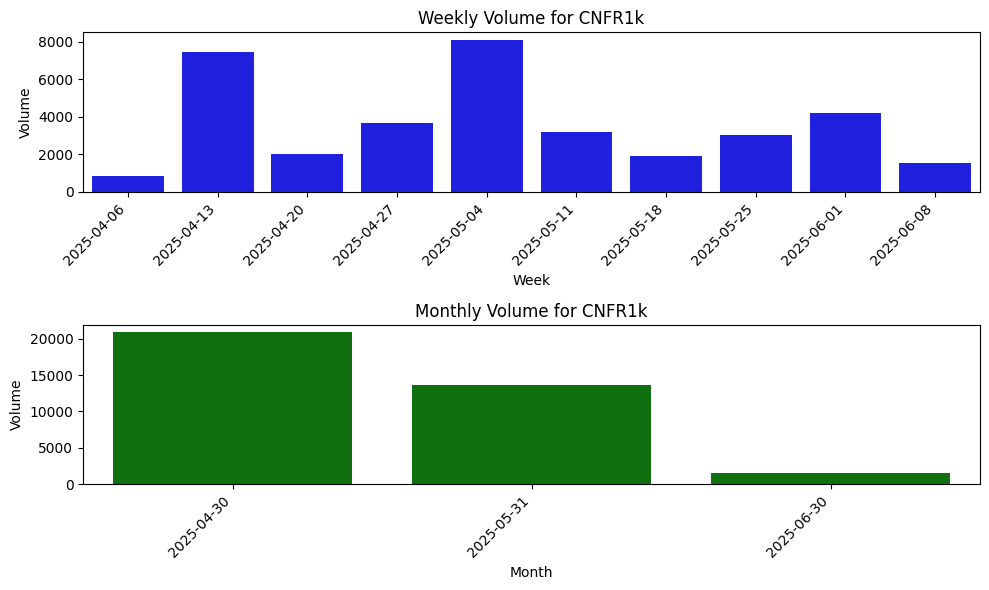

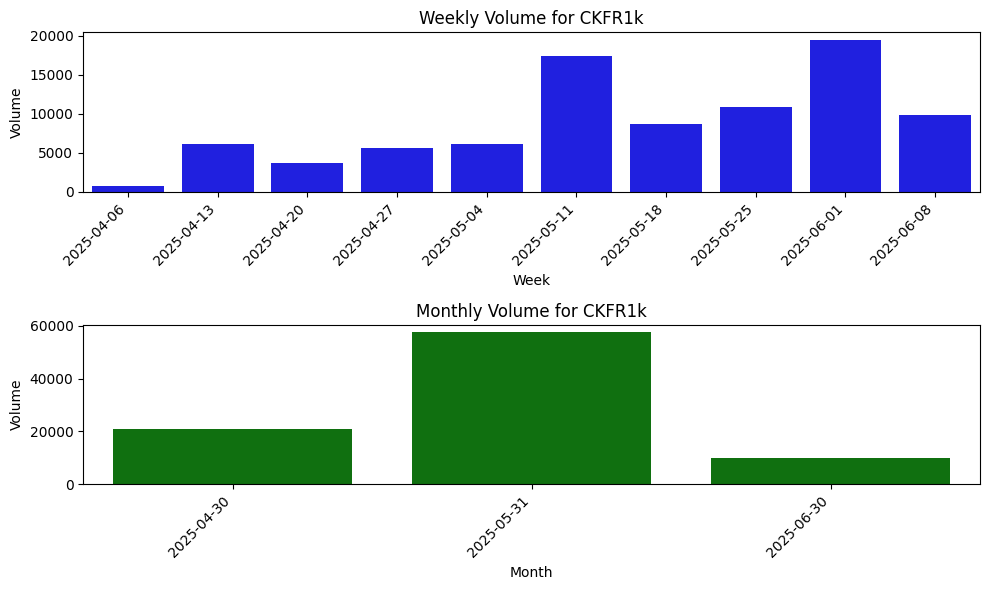

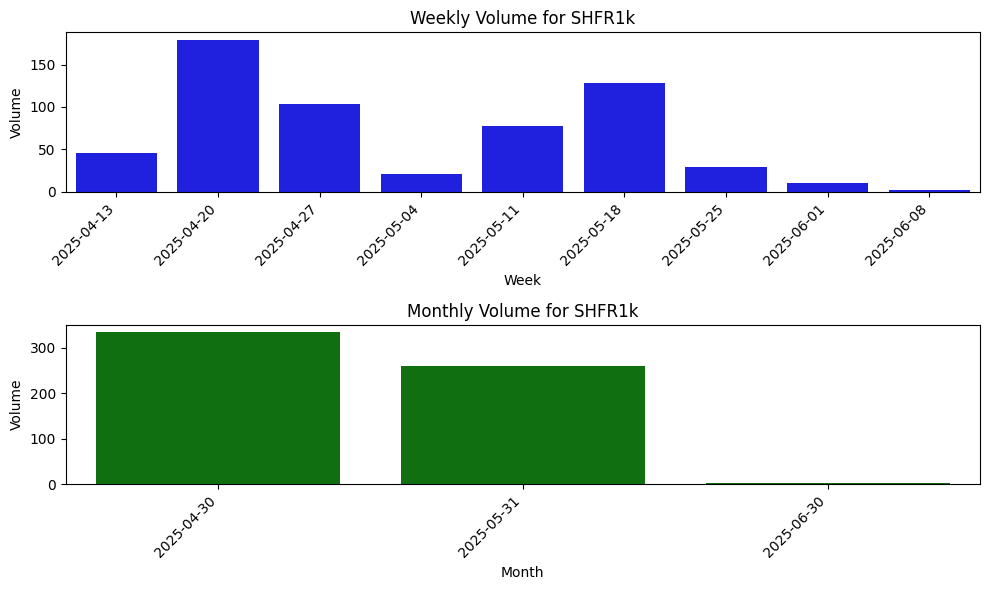

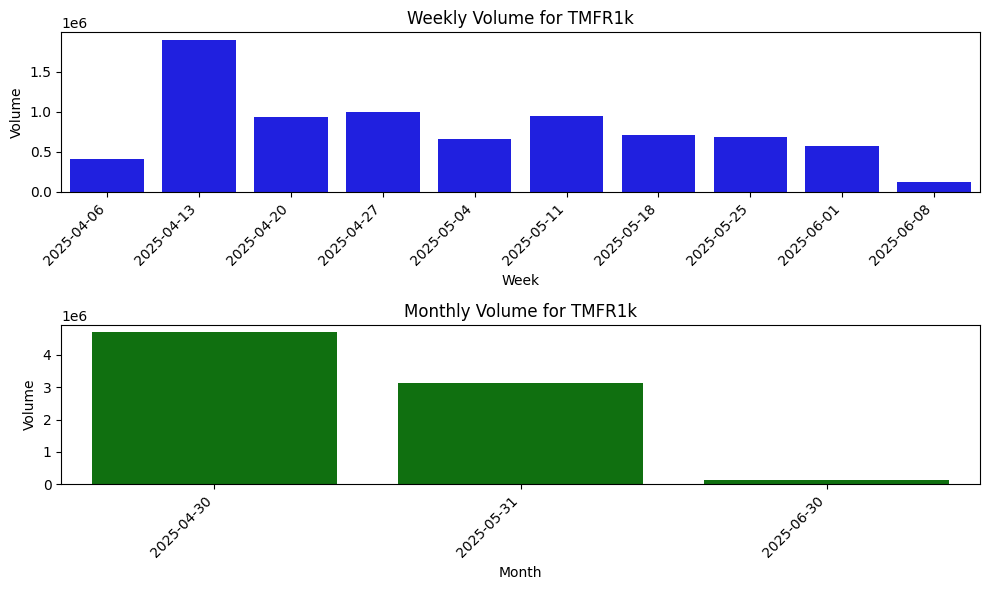

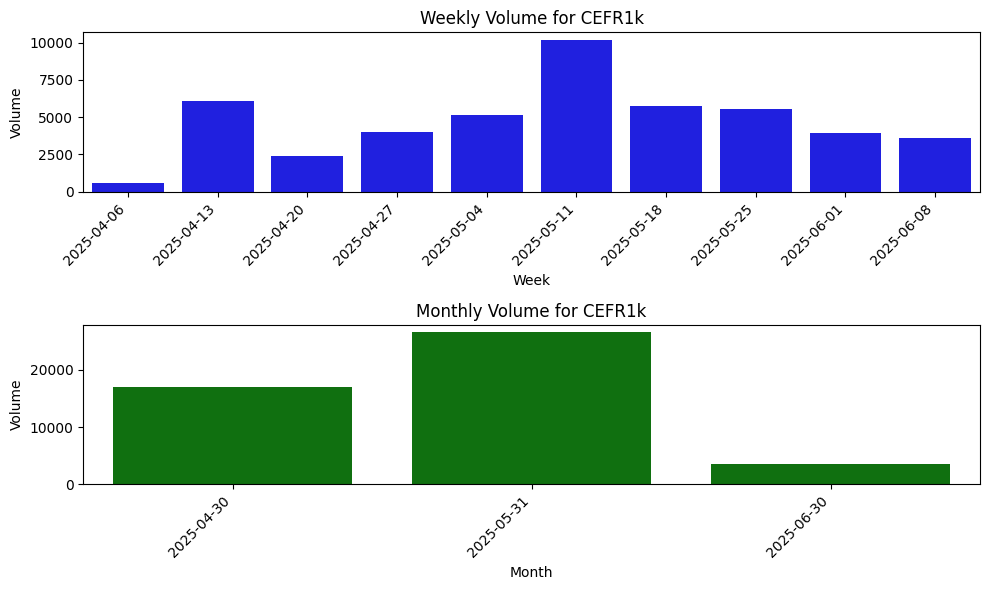

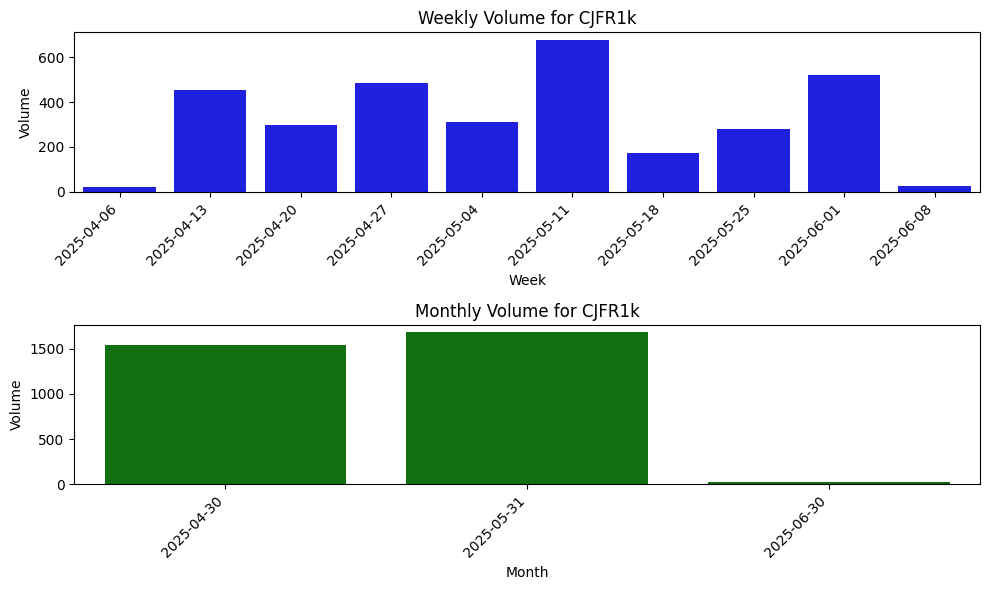

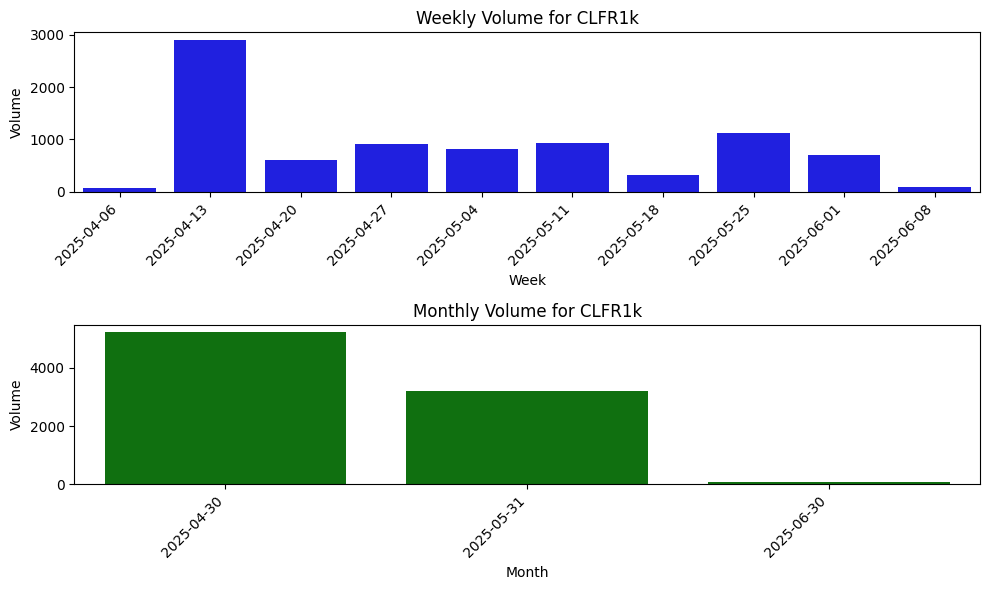

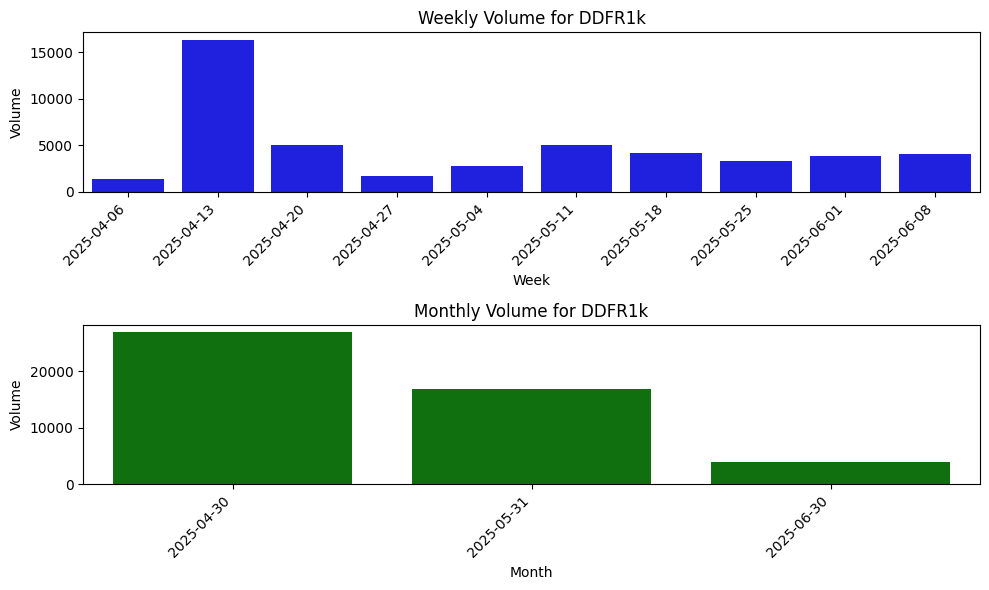

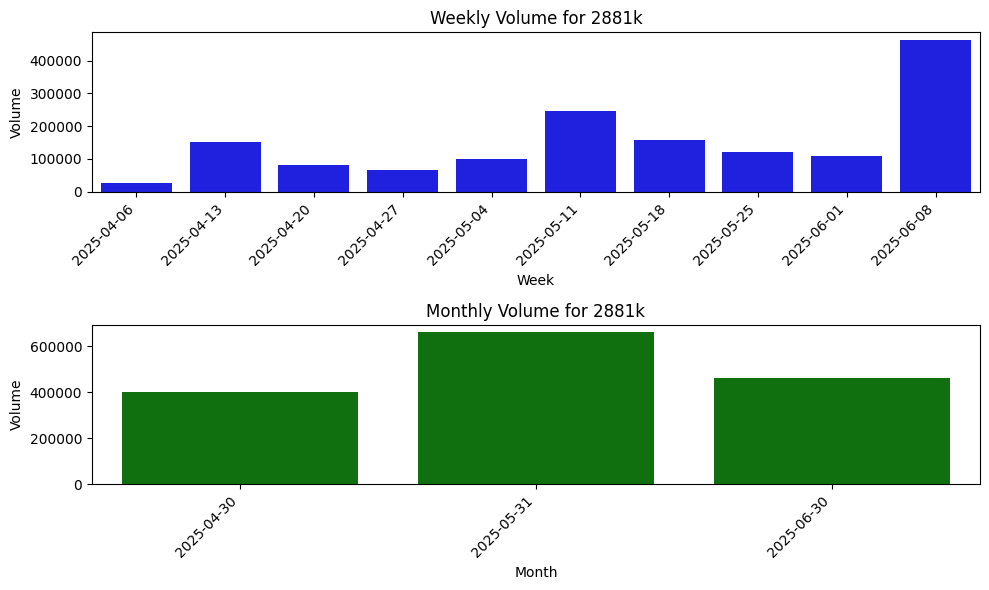

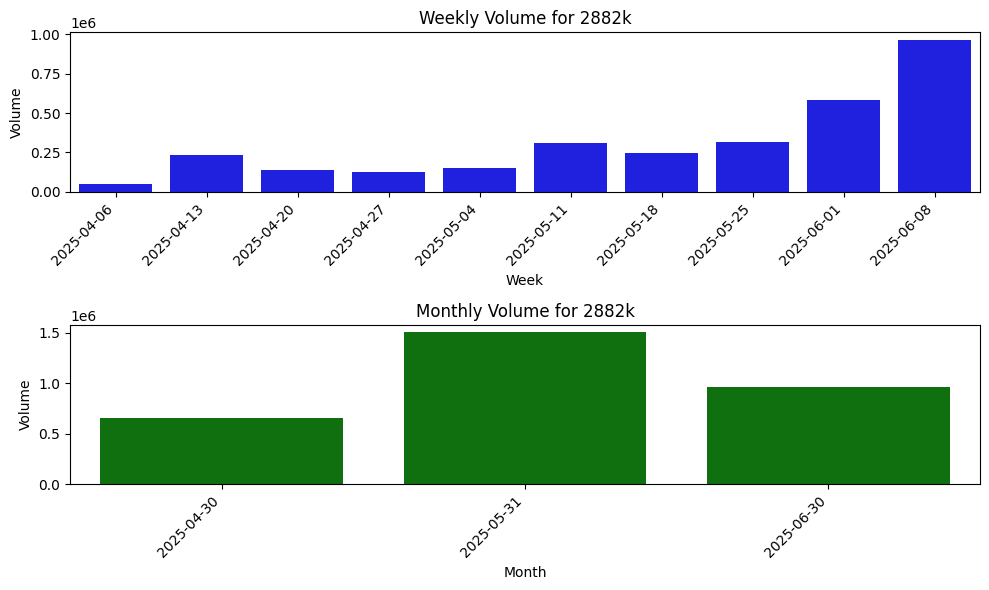

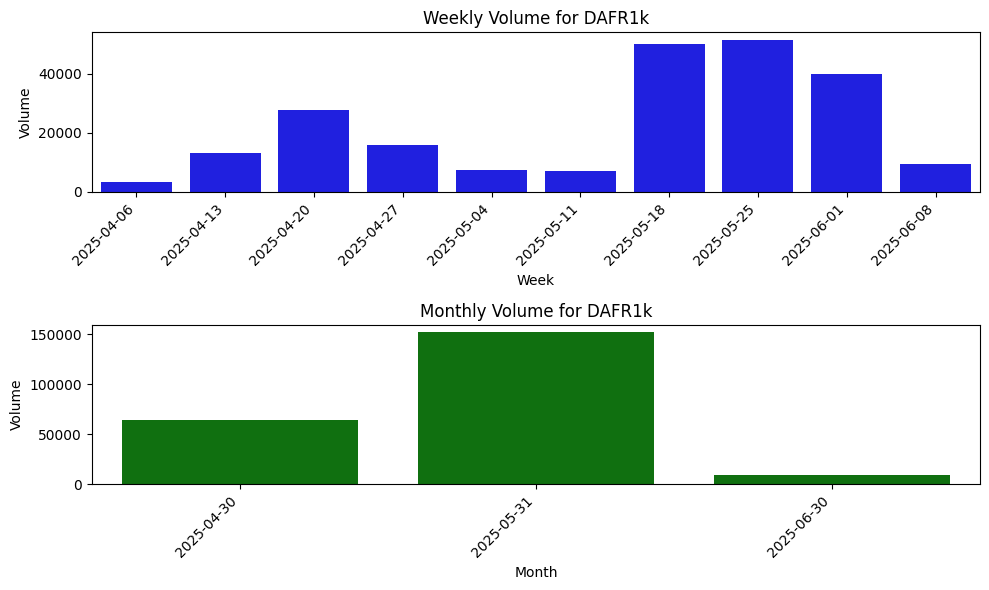

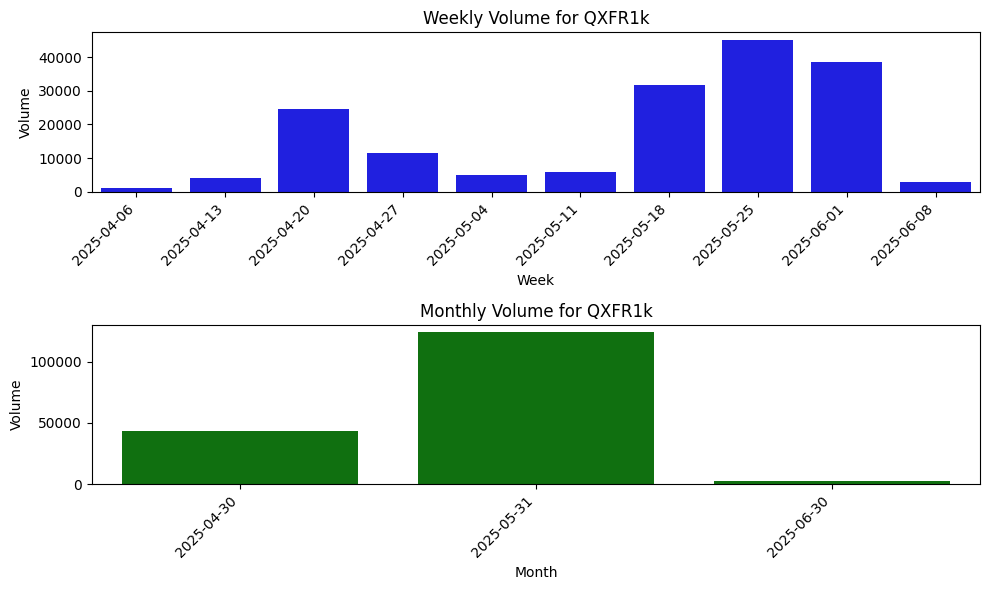


Weekly Volume Bins by File:
Volume_Bin  (-1896.678, 189869.8]  (189869.8, 379737.6]  (379737.6, 569605.4]  \
file                                                                            
2881k                           8                     1                     1   
2882k                           4                     4                     0   
CEFR1k                         10                     0                     0   
CJFR1k                         10                     0                     0   
CKFR1k                         10                     0                     0   
CLFR1k                         10                     0                     0   
CNFR1k                         10                     0                     0   
DAFR1k                         10                     0                     0   
DDFR1k                         10                     0                     0   
QXFR1k                         10                     0                     0   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 設定目錄路徑
directory = "./index_data/shioaji/2025_0406"

# 初始化儲存加總結果的列表，包含檔案名稱
weekly_volumes = []
monthly_volumes = []

# 遍歷目錄下所有以 "k" 結尾的 .csv 檔案
for file in Path(directory).glob("*k.csv"):
    # 獲取檔案名稱（不含路徑和副檔名）
    file_name = file.stem  # 例如：TMFR1K.csv -> TMFR1K
    
    # 讀取 CSV 檔案
    df = pd.read_csv(file, parse_dates=['ts'])
    
    # 確保 'ts' 欄位是 datetime 格式
    df['ts'] = pd.to_datetime(df['ts'])
    
    # 按週加總成交量，並記錄對應檔案名稱
    df_weekly = df.resample('W', on='ts')['Volume'].sum().reset_index()
    for _, row in df_weekly.iterrows():
        weekly_volumes.append({'file': file_name, 'ts': row['ts'], 'Volume': row['Volume']})
    
    # 按月加總成交量，並記錄對應檔案名稱（使用 'ME' 避免警告）
    df_monthly = df.resample('ME', on='ts')['Volume'].sum().reset_index()
    for _, row in df_monthly.iterrows():
        monthly_volumes.append({'file': file_name, 'ts': row['ts'], 'Volume': row['Volume']})

# 將成交量轉為 DataFrame 用於分析
weekly_volumes = pd.DataFrame(weekly_volumes)
monthly_volumes = pd.DataFrame(monthly_volumes)

# 打印基本統計資訊
print("Weekly Volume Statistics:")
print(weekly_volumes.groupby('file')['Volume'].describe())
print("\nMonthly Volume Statistics:")
print(monthly_volumes.groupby('file')['Volume'].describe())

# 為每個商品單獨繪製週成交量和月成交量圖表
for file_name in weekly_volumes['file'].unique():
    # 篩選當前商品的數據
    weekly_data = weekly_volumes[weekly_volumes['file'] == file_name]
    monthly_data = monthly_volumes[monthly_volumes['file'] == file_name]
    
    # 創建新圖表
    plt.figure(figsize=(10, 6))
    
    # 週成交量柱狀圖
    plt.subplot(2, 1, 1)
    sns.barplot(data=weekly_data, x='ts', y='Volume', color='blue')
    plt.title(f'Weekly Volume for {file_name}')
    plt.xlabel('Week')
    plt.ylabel('Volume')
    plt.xticks(rotation=45, ha='right')
    
    # 月成交量柱狀圖
    plt.subplot(2, 1, 2)
    sns.barplot(data=monthly_data, x='ts', y='Volume', color='green')
    plt.title(f'Monthly Volume for {file_name}')
    plt.xlabel('Month')
    plt.ylabel('Volume')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# 詳細區間分析，使用 pd.cut 分類成交量（明確指定 observed=False）
bins = 10  # 可調整區間數量
weekly_volumes['Volume_Bin'] = pd.cut(weekly_volumes['Volume'], bins=bins)
monthly_volumes['Volume_Bin'] = pd.cut(monthly_volumes['Volume'], bins=bins)

print("\nWeekly Volume Bins by File:")
print(weekly_volumes.groupby(['file', 'Volume_Bin'], observed=False)['Volume'].count().unstack().fillna(0))
print("\nMonthly Volume Bins by File:")
print(monthly_volumes.groupby(['file', 'Volume_Bin'], observed=False)['Volume'].count().unstack().fillna(0))

# 輸出每個檔案的週成交量與月成交量詳細資料
print("\nWeekly Volumes by File and Date:")
print(weekly_volumes[['file', 'ts', 'Volume']].sort_values(by=['file', 'ts']))
print("\nMonthly Volumes by File and Date:")
print(monthly_volumes[['file', 'ts', 'Volume']].sort_values(by=['file', 'ts']))

### 時間缺口檢查

In [158]:
# 定義起始和結束時間
start_time = pd.Timestamp('2025-04-28 12:30:00')
end_time = pd.Timestamp('2025-04-28 13:00:00')

# 建立遮罩：檢查完整的 Timestamp（日期和時間）
mask = (df.index >= start_time) & (df.index <= end_time)

# 使用遮罩篩選資料
filtered_df = df[mask]

# 顯示結果
print(filtered_df)

                     close_df1  volume_df1  \
ts                                           
2025-04-28 12:30:03       79.4         1.0   
2025-04-28 12:30:07       79.4         1.0   
2025-04-28 12:32:08       79.4         1.0   
2025-04-28 12:32:19       79.4         2.0   
2025-04-28 12:33:49       79.3         1.0   
2025-04-28 12:34:08       79.4         2.0   
2025-04-28 12:34:09       79.3         1.0   
2025-04-28 12:34:36       79.3         1.0   
2025-04-28 12:36:07       79.3         1.0   
2025-04-28 12:39:51       79.4         3.0   
2025-04-28 12:39:56       79.3         1.0   
2025-04-28 12:40:52       79.4         2.0   
2025-04-28 12:41:23       79.4         2.0   
2025-04-28 12:43:31       79.4         1.0   
2025-04-28 12:44:01       79.6       456.0   
2025-04-28 12:44:05       79.6         3.0   
2025-04-28 12:44:21       79.6        26.0   
2025-04-28 12:45:40       79.5         1.0   
2025-04-28 12:45:41       79.6         2.0   
2025-04-28 12:46:45       79.5    